## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [2365]:
# 계산
import numpy as np
from scipy.stats import mode
from collections import Counter
import time

# 전처리
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, TimeSeriesSplit
from imblearn.over_sampling import SMOTE

# 데이터셋 로드 및 정제
import os
import random
import joblib
import pandas as pd

# visualization
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 모델링
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import catboost
from catboost import CatBoostRegressor, Pool

# 스케일링
from sklearn.preprocessing import StandardScaler

# 평가지표
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import r2_score
# import eli5
# from eli5.sklearn import PermutationImportance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# hyperparameter tuning
import optuna
from functools import partial

# feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score


# 코드 셀 실행 후 경고를 무시
import warnings
warnings.filterwarnings(action='ignore')

## 2. Data Load

#### 2.1. 데이터 로드

In [2366]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = './train.csv'
test_path  = './test.csv'
df = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(df.shape, test.shape)

(252289, 19) (79786, 18)


In [2367]:
df.head()

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
0,SESSION_000000,USER_000000,17.0,Chrome,Macintosh,desktop,0,45.0,839.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
1,SESSION_000001,USER_000001,3.0,Chrome,Windows,desktop,1,1.0,39.0,0,0.0,0.0,Europe,Western Europe,Germany,google,organic,Category8,NaN
2,SESSION_000002,USER_000002,1.0,Samsung Internet,Android,mobile,1,1.0,0.0,1,0.0,0.0,Asia,Southeast Asia,Malaysia,(direct),(none),NaN,NaN
3,SESSION_000003,USER_000003,1.0,Chrome,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,Partners,affiliate,NaN,NaN
4,SESSION_000004,USER_000004,1.0,Chrome,iOS,mobile,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,groups.google.com,referral,NaN,Category6_Path_0000


In [2368]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252289 entries, 0 to 252288
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sessionID            252289 non-null  object 
 1   userID               252289 non-null  object 
 2   TARGET               252289 non-null  float64
 3   browser              252289 non-null  object 
 4   OS                   252289 non-null  object 
 5   device               252289 non-null  object 
 6   new                  252289 non-null  int64  
 7   quality              252289 non-null  float64
 8   duration             252289 non-null  float64
 9   bounced              252289 non-null  int64  
 10  transaction          252289 non-null  float64
 11  transaction_revenue  252289 non-null  float64
 12  continent            252289 non-null  object 
 13  subcontinent         252289 non-null  object 
 14  country              252289 non-null  object 
 15  traffic_source   

In [2369]:
df.describe()

,TARGET,new,quality,duration,bounced,transaction,transaction_revenue
count,252289.000000,252289.000000,252289.000000,252289.000000,252289.000000,252289.000000,2.522890e+05
mean,3.592626,0.751955,3.816805,113.104253,0.493672,0.009033,9.061248e+05
std,5.509465,0.431879,11.091028,330.876019,0.499961,0.100938,2.127689e+07
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000e+00
75%,4.000000,1.000000,1.000000,71.000000,1.000000,0.000000,0.000000e+00
max,386.000000,1.000000,98.000000,11186.000000,1.000000,12.000000,3.325712e+09


In [2370]:
df.isna().sum()

sessionID                   0
userID                      0
TARGET                      0
browser                     0
OS                          0
device                      0
new                         0
quality                     0
duration                    0
bounced                     0
transaction                 0
transaction_revenue         0
continent                   0
subcontinent                0
country                     0
traffic_source              0
traffic_medium              0
keyword                137675
referral_path          161107
dtype: int64

In [2371]:
df.columns

Index(['sessionID', 'userID', 'TARGET', 'browser', 'OS', 'device', 'new',
       'quality', 'duration', 'bounced', 'transaction', 'transaction_revenue',
       'continent', 'subcontinent', 'country', 'traffic_source',
       'traffic_medium', 'keyword', 'referral_path'],
      dtype='object')

## 3. Data EDA

### 3.1. Target 데이터 분석

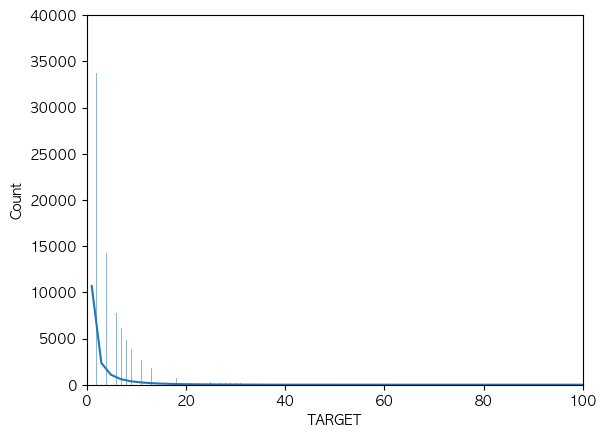

In [2372]:
# 데이터를 시각화
sns.histplot(x='TARGET', data=df, kde=True)

plt.xlim(0, 100)
plt.ylim(0, 40000)

# 그래프를 표시
plt.show()

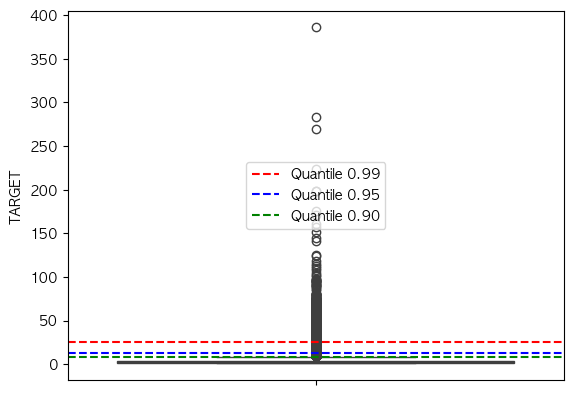

99% : 26.0 95% : 13.0 90% : 8.0


In [2373]:
sns.boxplot(y='TARGET', data=df)

# quantile(0.99), quantile(0.95), quantile(0.90) 계산
q99 = np.quantile(df['TARGET'], 0.99)
q95 = np.quantile(df['TARGET'], 0.95)
q90 = np.quantile(df['TARGET'], 0.90)
    
# 점선 추가
plt.axhline(y=q99, color='red', linestyle='--', label='Quantile 0.99')
plt.axhline(y=q95, color='blue', linestyle='--', label='Quantile 0.95')
plt.axhline(y=q90, color='green', linestyle='--', label='Quantile 0.90')
plt.legend(loc="center")

plt.show()

print('99% :', q99, '95% :', q95, '90% :', q90)

In [2374]:
df[df['TARGET']<=0]

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path


In [2375]:
df[df['TARGET']>=100]

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
10966,SESSION_010966,USER_007922,386.0,Firefox,Windows,desktop,0,65.0,6470.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
13498,SESSION_013498,USER_011820,270.0,Android Webview,Android,mobile,1,7.0,360.0,0,0.0,0.0,Americas,South America,Brazil,(direct),(none),NaN,NaN
23793,SESSION_023793,USER_020520,171.0,Chrome,Windows,desktop,1,18.0,6470.0,0,2.0,126439360.0,Americas,South America,Venezuela,google,organic,Category8,NaN
49819,SESSION_049819,USER_041591,125.0,Chrome,Android,tablet,1,18.0,2120.0,0,0.0,0.0,Americas,Northern America,United States,youtube.com,referral,NaN,Category8_Path_0025
60549,SESSION_060549,USER_050216,157.0,Chrome,Windows,desktop,1,16.0,4194.0,0,2.0,442613280.0,Americas,South America,Venezuela,google,organic,Category8,NaN
95538,SESSION_095538,USER_066687,145.0,Chrome,Macintosh,desktop,0,87.0,3751.0,0,7.0,402474400.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
100318,SESSION_100318,USER_039312,161.0,Chrome,Macintosh,desktop,0,87.0,4148.0,0,12.0,649821280.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
140686,SESSION_140686,USER_116545,115.0,Chrome,Android,tablet,1,1.0,105.0,0,0.0,0.0,Americas,Northern America,United States,youtube.com,referral,NaN,Category11_Path_1082
141138,SESSION_141138,USER_116907,152.0,Chrome,Android,mobile,1,33.0,601.0,0,0.0,0.0,Americas,Northern America,United States,google.com,referral,NaN,Category9_Path_0374
149196,SESSION_149196,USER_123248,118.0,Chrome,Android,mobile,1,1.0,84.0,0,0.0,0.0,Africa,Southern Africa,South Africa,google.com,referral,NaN,Category9_Path_0005


### 3.2. 범주형 데이터 분석

#### sessionID, userID

In [2376]:
df['sessionID'].nunique()

252289

In [2377]:
df['userID'].nunique()

206024

In [2378]:
# userID 별로 그룹화하고 각 그룹의 크기가 2 이상인 그룹만 필터링
filtered_df = df.groupby('userID').filter(lambda x: len(x) > 1)
filtered_df2 = df.groupby('userID').filter(lambda x: len(x) == 1)
# 중복되는 userID만 추출
unique_userIDs = filtered_df['userID'].unique()
unique_userIDs2 = filtered_df2['userID'].unique()

print(unique_userIDs)
print(len(unique_userIDs2) + len(unique_userIDs) * 2)
df['sessionID'].nunique()

['USER_000004' 'USER_000005' 'USER_000014' ... 'USER_205961' 'USER_205962'
 'USER_206012']
232282


252289

In [2379]:
filtered_df = df.groupby('userID').filter(lambda x: len(x) > 10)
unique_userIDs = filtered_df['userID'].unique()
print(len(unique_userIDs))

246


같은 유저는 조회수를 합쳐야 할까..?

#### browser

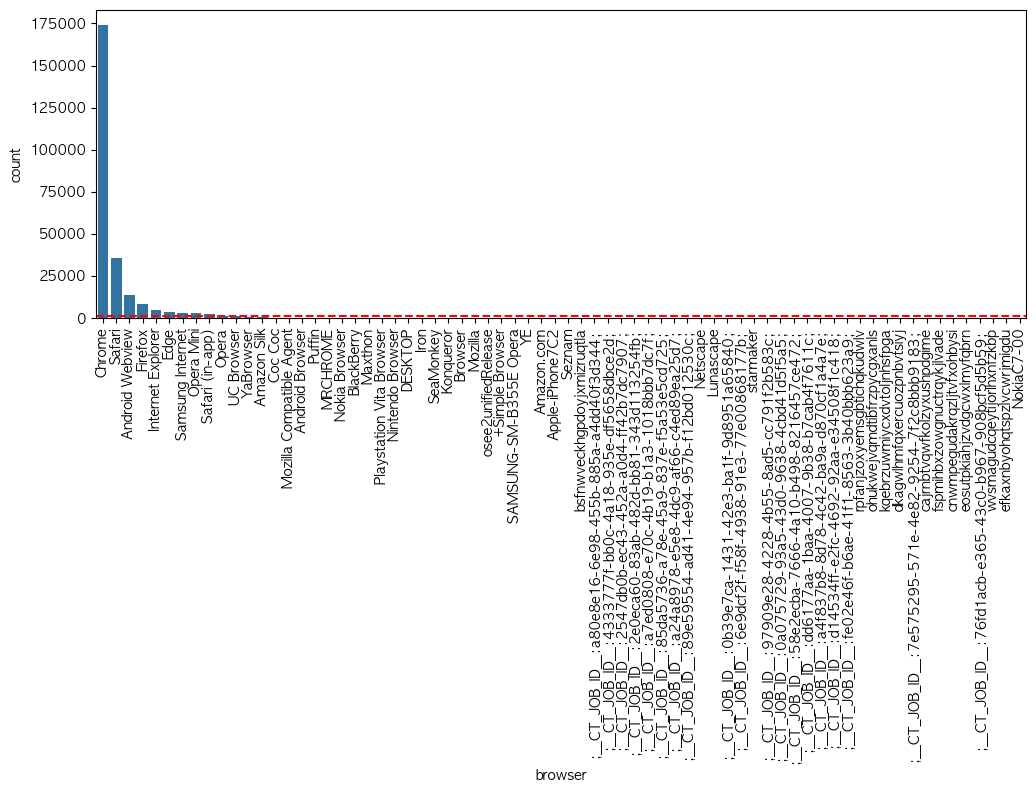

In [2380]:
order = df['browser'].value_counts().index
plt.figure(figsize=(12, 4)) 
sns.countplot(x = 'browser', data=df, order=order)
plt.xticks(rotation=90)
plt.axhline(y=1000, color='r', linestyle='--')
plt.show()

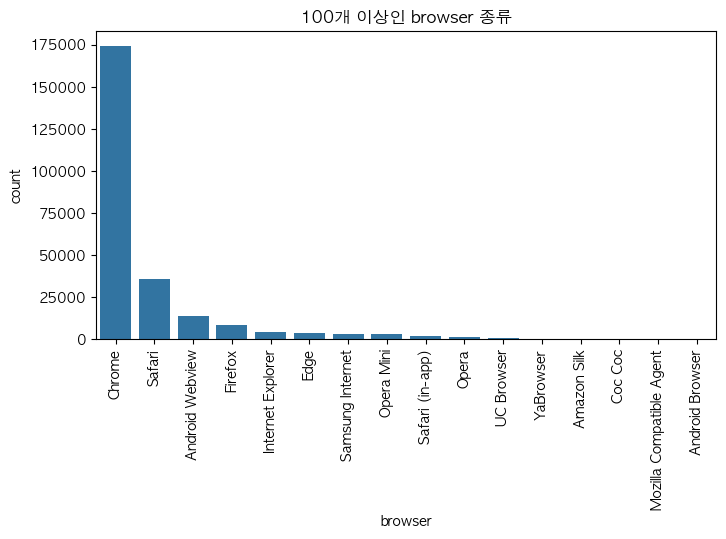

In [2381]:
# 'browser'의 빈도수 계산
browser_counts = df['browser'].value_counts()

# 1000개 이상의 레코드를 가진 'browser'만 필터링
filtered_browsers = browser_counts[browser_counts > 100].index

# 필터링된 'browser'에 해당하는 데이터만 선택
filtered_df = df[df['browser'].isin(filtered_browsers)]

# 시각화
plt.figure(figsize=(8, 4))
sns.countplot(x='browser', data=filtered_df, order=filtered_browsers)
plt.xticks(rotation=90)
plt.title("100개 이상인 browser 종류")

plt.show()

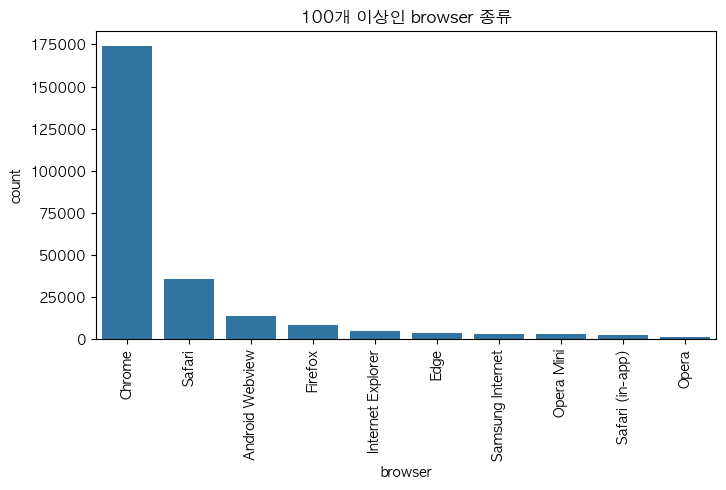

In [2382]:
# 'browser'의 빈도수 계산
browser_counts = df['browser'].value_counts()

# 1000개 이상의 레코드를 가진 'browser'만 필터링
filtered_browsers = browser_counts[browser_counts > 1000].index

# 필터링된 'browser'에 해당하는 데이터만 선택
filtered_df = df[df['browser'].isin(filtered_browsers)]

# 시각화
plt.figure(figsize=(8, 4))
sns.countplot(x='browser', data=filtered_df, order=filtered_browsers)
plt.xticks(rotation=90)
plt.title("100개 이상인 browser 종류")

plt.show()

#### OS

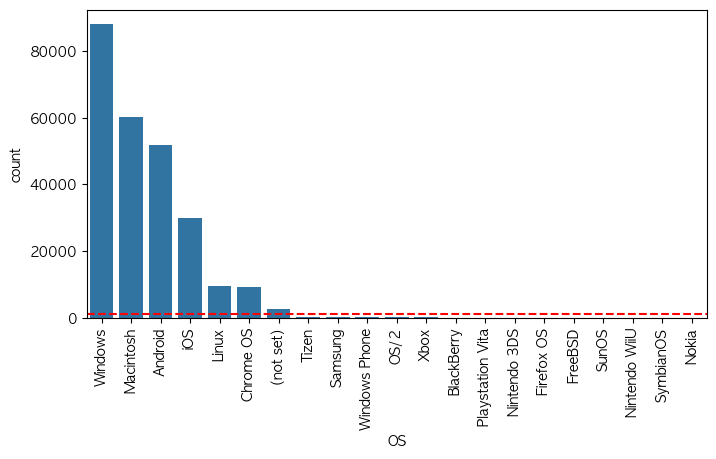

In [2383]:
order = df['OS'].value_counts().index
plt.figure(figsize=(8, 4)) 
sns.countplot(x = 'OS', data=df, order=order)
plt.xticks(rotation=90)
plt.axhline(y=1000, color='r', linestyle='--')
plt.show()

In [2384]:
df[df['OS']=='(not set)']

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
164,SESSION_000164,USER_000158,1.0,Opera Mini,(not set),mobile,1,1.0,0.0,1,0.0,0.0,Asia,Southern Asia,Pakistan,(direct),(none),NaN,NaN
494,SESSION_000494,USER_000466,1.0,Chrome,(not set),desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
596,SESSION_000596,USER_000560,1.0,Opera Mini,(not set),mobile,1,1.0,0.0,1,0.0,0.0,Africa,Western Africa,Nigeria,(direct),(none),NaN,NaN
602,SESSION_000602,USER_000566,3.0,Opera Mini,(not set),mobile,1,1.0,103.0,0,0.0,0.0,Asia,Southern Asia,Bangladesh,(direct),(none),NaN,Category1
630,SESSION_000630,USER_000592,2.0,Opera Mini,(not set),mobile,1,1.0,237.0,0,0.0,0.0,Africa,Western Africa,Benin,(direct),(none),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251982,SESSION_251982,USER_205801,1.0,Opera Mini,(not set),mobile,1,1.0,0.0,1,0.0,0.0,Africa,Northern Africa,Egypt,(direct),(none),NaN,NaN
252032,SESSION_252032,USER_203631,1.0,Opera Mini,(not set),mobile,0,1.0,0.0,1,0.0,0.0,Africa,Western Africa,Nigeria,youtube.com,referral,NaN,Category5_Path_0006
252141,SESSION_252141,USER_205915,1.0,Opera Mini,(not set),mobile,1,1.0,0.0,1,0.0,0.0,Asia,Southeast Asia,Thailand,(direct),(none),NaN,NaN
252144,SESSION_252144,USER_203631,1.0,Opera Mini,(not set),mobile,0,1.0,0.0,1,0.0,0.0,Africa,Western Africa,Nigeria,youtube.com,referral,NaN,Category5_Path_0006


#### device

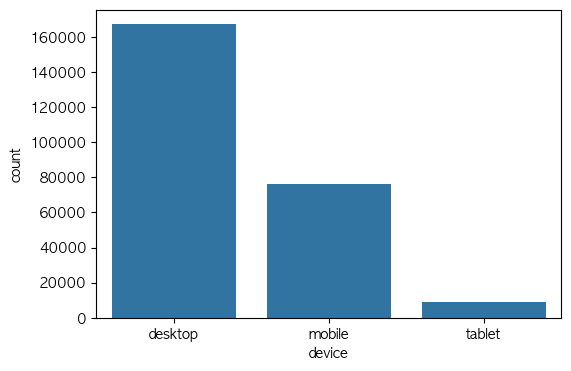

In [2385]:
order = df['device'].value_counts().index
plt.figure(figsize=(6, 4)) 
sns.countplot(x = 'device', data=df, order=order)
plt.show()

#### continent

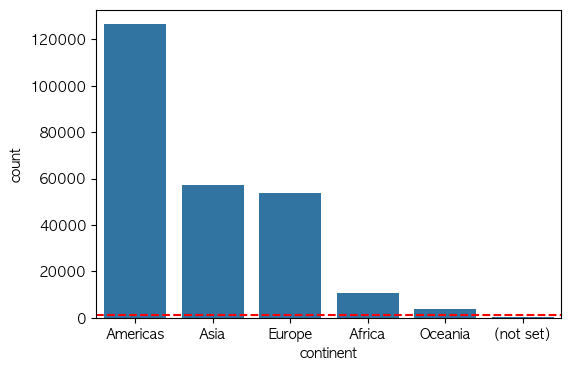

In [2386]:
order = df['continent'].value_counts().index
plt.figure(figsize=(6, 4)) 
sns.countplot(x = 'continent', data=df, order=order)
plt.axhline(y=1000, color='r', linestyle='--')
plt.show()

In [2387]:
df[df['continent']=='(not set)']

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
978,SESSION_000978,USER_000912,1.0,Safari (in-app),iOS,mobile,1,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),google,cpc,Category9,NaN
1065,SESSION_001065,USER_000991,1.0,Chrome,Android,mobile,1,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),(direct),(none),NaN,NaN
2012,SESSION_002012,USER_001844,4.0,Chrome,Windows,desktop,1,1.0,39.0,0,0.0,0.0,(not set),(not set),(not set),(direct),(none),NaN,NaN
2781,SESSION_002781,USER_002546,1.0,Chrome,Android,mobile,0,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),(direct),(none),NaN,NaN
3077,SESSION_003077,USER_002546,2.0,Chrome,Android,mobile,0,1.0,8.0,0,0.0,0.0,(not set),(not set),(not set),(direct),(none),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250035,SESSION_250035,USER_204316,1.0,Chrome,Windows,desktop,1,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),google,organic,Category8,NaN
250612,SESSION_250612,USER_204769,1.0,Chrome,Windows,desktop,1,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),analytics.google.com,referral,NaN,Category3_Path_0013
250654,SESSION_250654,USER_204805,3.0,Chrome,Windows,desktop,1,1.0,33.0,0,0.0,0.0,(not set),(not set),(not set),google,organic,Category8,NaN
251144,SESSION_251144,USER_205183,1.0,Internet Explorer,Windows,desktop,1,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),youtube.com,referral,NaN,Category13_Path_0029


#### subcontinent

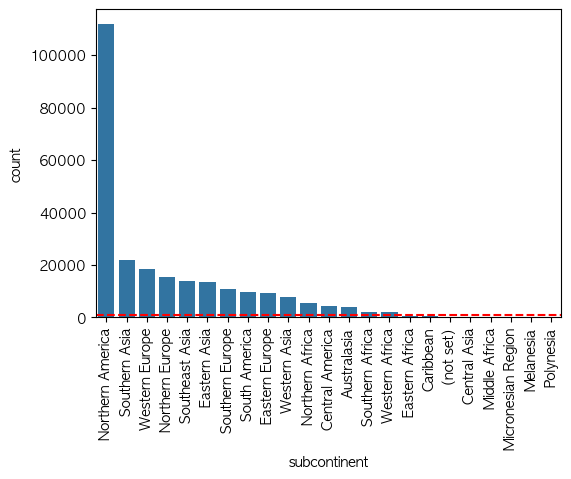

In [2388]:
order = df['subcontinent'].value_counts().index
plt.figure(figsize=(6, 4)) 
sns.countplot(x = 'subcontinent', data=df, order=order)
plt.axhline(y=1000, color='r', linestyle='--')
plt.xticks(rotation=90)
plt.show()

In [2389]:
df[df['subcontinent']=='(not set)']

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
978,SESSION_000978,USER_000912,1.0,Safari (in-app),iOS,mobile,1,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),google,cpc,Category9,NaN
1065,SESSION_001065,USER_000991,1.0,Chrome,Android,mobile,1,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),(direct),(none),NaN,NaN
2012,SESSION_002012,USER_001844,4.0,Chrome,Windows,desktop,1,1.0,39.0,0,0.0,0.0,(not set),(not set),(not set),(direct),(none),NaN,NaN
2781,SESSION_002781,USER_002546,1.0,Chrome,Android,mobile,0,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),(direct),(none),NaN,NaN
3077,SESSION_003077,USER_002546,2.0,Chrome,Android,mobile,0,1.0,8.0,0,0.0,0.0,(not set),(not set),(not set),(direct),(none),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250035,SESSION_250035,USER_204316,1.0,Chrome,Windows,desktop,1,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),google,organic,Category8,NaN
250612,SESSION_250612,USER_204769,1.0,Chrome,Windows,desktop,1,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),analytics.google.com,referral,NaN,Category3_Path_0013
250654,SESSION_250654,USER_204805,3.0,Chrome,Windows,desktop,1,1.0,33.0,0,0.0,0.0,(not set),(not set),(not set),google,organic,Category8,NaN
251144,SESSION_251144,USER_205183,1.0,Internet Explorer,Windows,desktop,1,1.0,0.0,1,0.0,0.0,(not set),(not set),(not set),youtube.com,referral,NaN,Category13_Path_0029


In [2390]:
df[df['continent']=='(not set)'].index.equals(df[df['subcontinent']=='(not set)'].index)

True

#### country

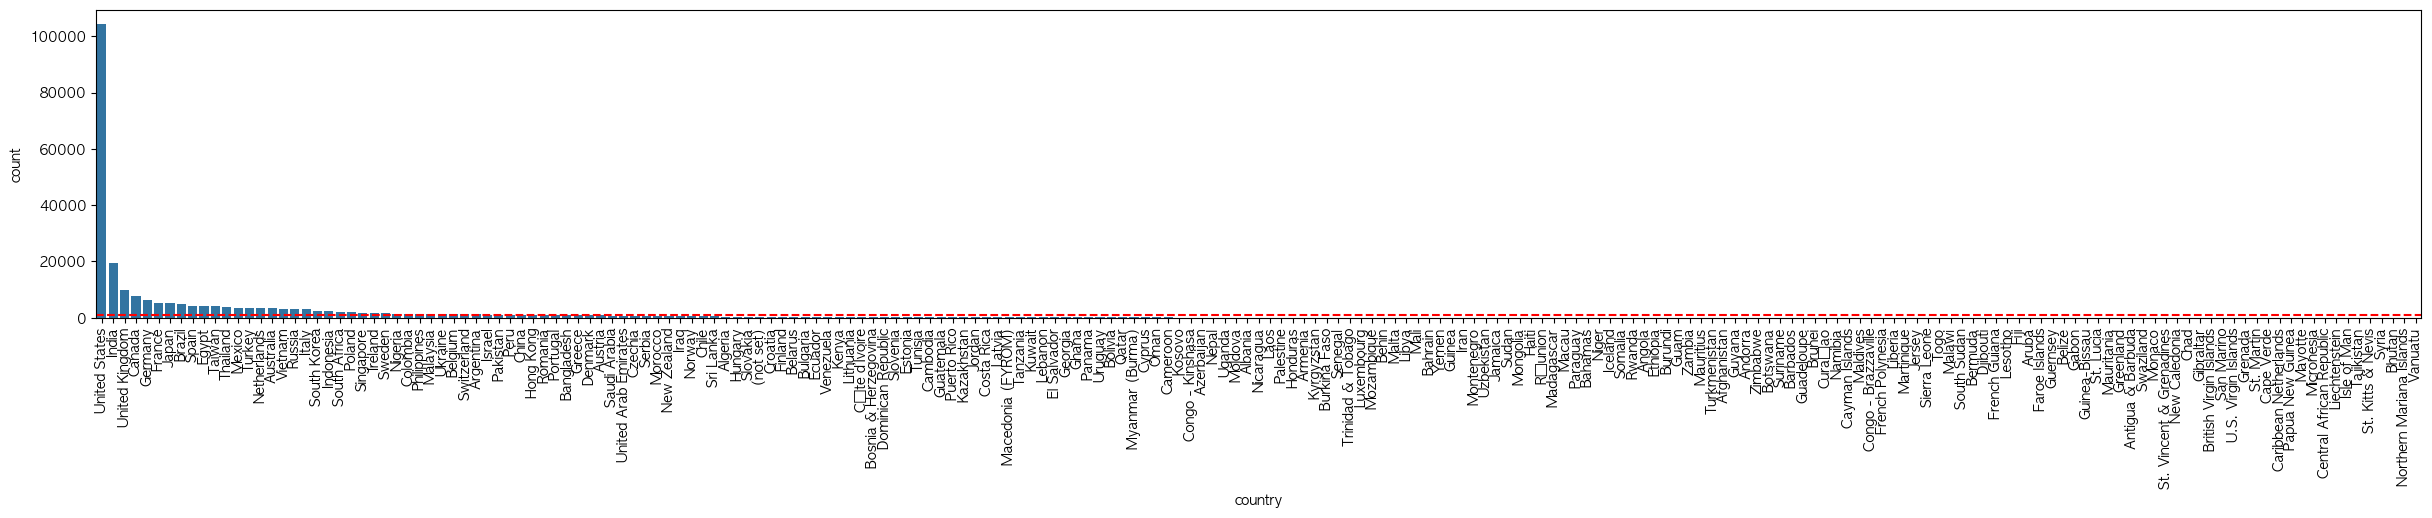

In [2391]:
order = df['country'].value_counts().index
plt.figure(figsize=(30, 4)) 
sns.countplot(x = 'country', data=df, order=order)
plt.axhline(y=1000, color='r', linestyle='--')
plt.xticks(rotation=90)
plt.show()

In [2392]:
df['country'].nunique()

205

#### traffic_source

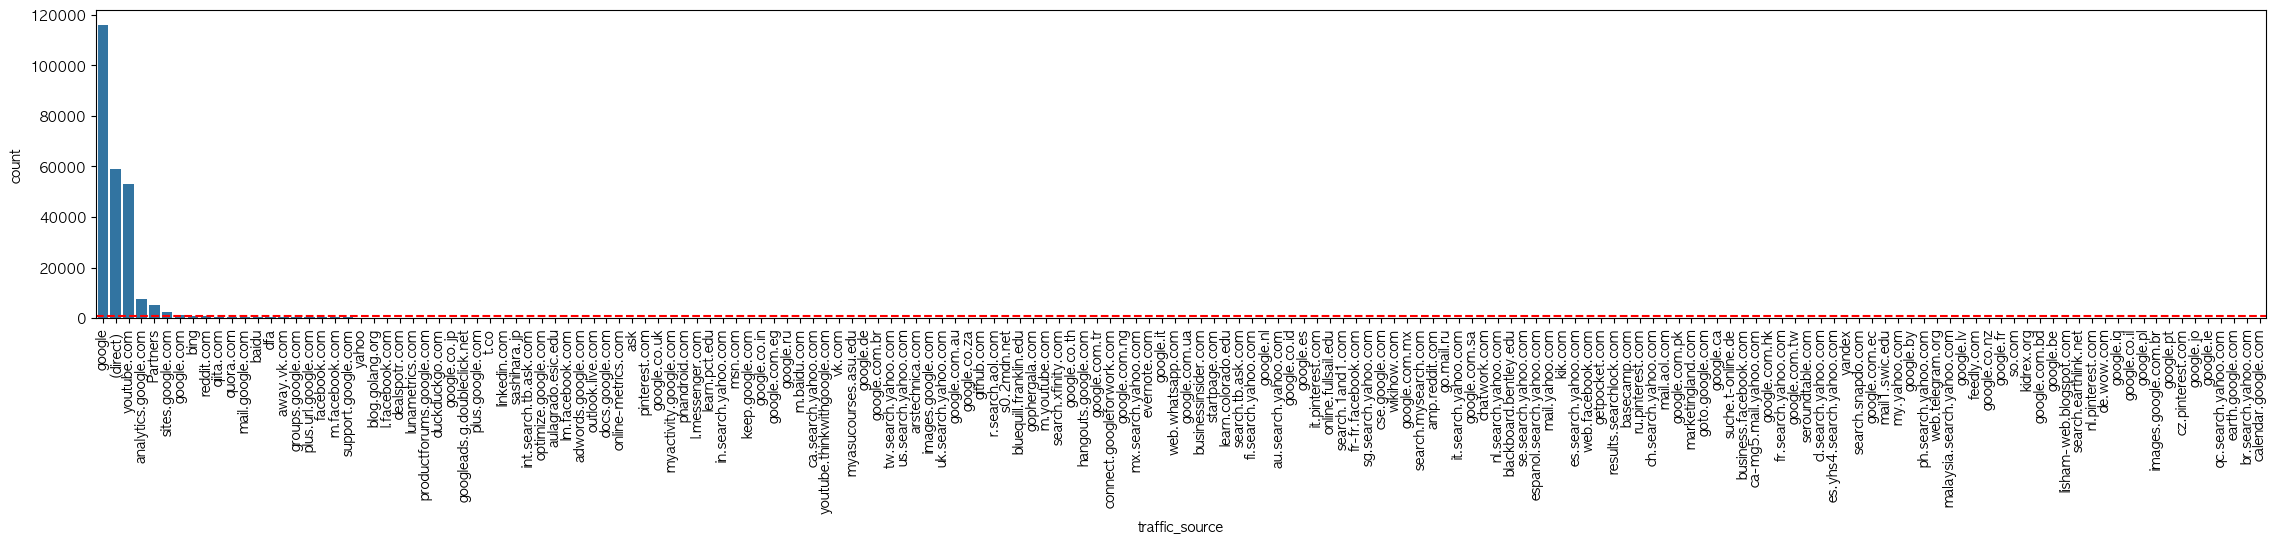

In [2393]:
order = df['traffic_source'].value_counts().index
plt.figure(figsize=(28, 4)) 
sns.countplot(x = 'traffic_source', data=df, order=order)
plt.axhline(y=1000, color='r', linestyle='--')
plt.xticks(rotation=90)
plt.show()

In [2394]:
df['traffic_source'].nunique()

168

#### traffic_medium

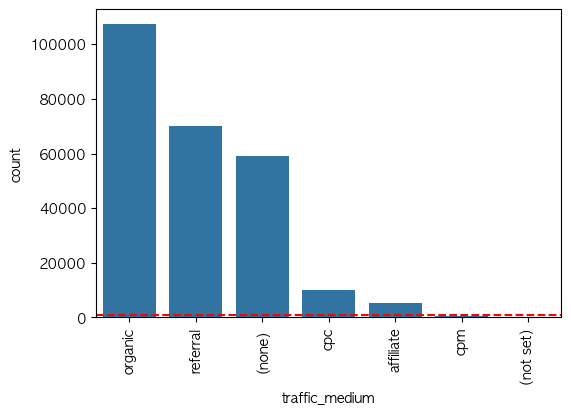

In [2395]:
order = df['traffic_medium'].value_counts().index
plt.figure(figsize=(6, 4)) 
sns.countplot(x = 'traffic_medium', data=df, order=order)
plt.axhline(y=1000, color='r', linestyle='--')
plt.xticks(rotation=90)
plt.show()

In [2396]:
df[df['traffic_medium']=='(none)']

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
2,SESSION_000002,USER_000002,1.0,Samsung Internet,Android,mobile,1,1.0,0.0,1,0.0,0.0,Asia,Southeast Asia,Malaysia,(direct),(none),NaN,NaN
10,SESSION_000010,USER_000010,6.0,Chrome,Windows,desktop,1,1.0,28.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
13,SESSION_000013,USER_000013,1.0,Opera,Linux,desktop,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
15,SESSION_000015,USER_000015,1.0,Samsung Internet,Android,mobile,1,1.0,0.0,1,0.0,0.0,Europe,Western Europe,Germany,(direct),(none),NaN,NaN
29,SESSION_000029,USER_000029,2.0,Chrome,Android,mobile,1,1.0,10.0,0,0.0,0.0,Europe,Eastern Europe,Poland,(direct),(none),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252277,SESSION_252277,USER_206015,2.0,Chrome,iOS,mobile,1,1.0,37.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
252279,SESSION_252279,USER_206012,6.0,Chrome,Windows,desktop,0,3.0,25.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
252280,SESSION_252280,USER_206017,5.0,Chrome,Macintosh,desktop,1,1.0,67.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
252286,SESSION_252286,USER_164240,5.0,Chrome,Macintosh,desktop,0,2.0,69.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1


In [2397]:
df[df['traffic_source']=='(direct)'].index.equals(df[df['traffic_medium']=='(none)'].index)

False

In [2398]:
df[(df['traffic_source']!='(direct)') & (df['traffic_medium']=='(none)')]

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path


In [2399]:
df[df['traffic_medium']=='(none)'].index.equals(df[df['traffic_source']=='(direct)'].index)

False

In [2400]:
df[df['traffic_source']=='(direct)']

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
2,SESSION_000002,USER_000002,1.0,Samsung Internet,Android,mobile,1,1.0,0.0,1,0.0,0.0,Asia,Southeast Asia,Malaysia,(direct),(none),NaN,NaN
10,SESSION_000010,USER_000010,6.0,Chrome,Windows,desktop,1,1.0,28.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
13,SESSION_000013,USER_000013,1.0,Opera,Linux,desktop,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
15,SESSION_000015,USER_000015,1.0,Samsung Internet,Android,mobile,1,1.0,0.0,1,0.0,0.0,Europe,Western Europe,Germany,(direct),(none),NaN,NaN
29,SESSION_000029,USER_000029,2.0,Chrome,Android,mobile,1,1.0,10.0,0,0.0,0.0,Europe,Eastern Europe,Poland,(direct),(none),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252277,SESSION_252277,USER_206015,2.0,Chrome,iOS,mobile,1,1.0,37.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
252279,SESSION_252279,USER_206012,6.0,Chrome,Windows,desktop,0,3.0,25.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
252280,SESSION_252280,USER_206017,5.0,Chrome,Macintosh,desktop,1,1.0,67.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
252286,SESSION_252286,USER_164240,5.0,Chrome,Macintosh,desktop,0,2.0,69.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1


In [2401]:
# 'traffic_source'가 '(direct)'인 데이터의 인덱스 집합
direct_index_set = set(df[df['traffic_source'] == '(direct)'].index)

# 'traffic_medium'이 '(none)'인 데이터의 인덱스 집합
none_index_set = set(df[df['traffic_medium'] == '(none)'].index)

# 두 조건을 모두 만족하는 데이터의 인덱스 집합 (교집합)
intersection_set = direct_index_set & none_index_set

# 해당 인덱스 집합에서 교집합을 제외하여, 조건을 만족하지 않는 데이터의 인덱스 찾기
index_set = set(df[df['traffic_source']=='(direct)'].index)
difference_set = index_set - intersection_set

# 조건을 만족하지 않는 데이터의 인덱스를 사용하여 해당 데이터 추출
non_matching_data = df.loc[difference_set]

# 결과 확인
non_matching_data

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
99368,SESSION_099368,USER_082847,1.0,Chrome,Macintosh,desktop,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,(direct),cpm,NaN,NaN
92065,SESSION_092065,USER_076786,1.0,Chrome,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,(direct),cpm,NaN,NaN
97014,SESSION_097014,USER_076786,1.0,Chrome,Macintosh,desktop,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,(direct),cpm,NaN,NaN
237927,SESSION_237927,USER_195116,1.0,Chrome,Android,mobile,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,(direct),cpm,NaN,NaN


In [2402]:
df[df['traffic_medium']=='cpm']

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
24,SESSION_000024,USER_000024,1.0,Safari,iOS,mobile,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,cpm,NaN,NaN
134,SESSION_000134,USER_000024,1.0,Safari,iOS,mobile,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,cpm,NaN,NaN
172,SESSION_000172,USER_000024,1.0,Safari,iOS,mobile,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,cpm,NaN,NaN
347,SESSION_000347,USER_000024,1.0,Safari,iOS,mobile,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,cpm,NaN,NaN
449,SESSION_000449,USER_000024,2.0,Safari,iOS,mobile,0,2.0,447.0,0,0.0,0.0,Americas,Northern America,United States,google,cpm,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244026,SESSION_244026,USER_199834,1.0,Chrome,Linux,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,Canada,dfa,cpm,NaN,NaN
244033,SESSION_244033,USER_199838,1.0,Chrome,Linux,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,Canada,dfa,cpm,NaN,NaN
250649,SESSION_250649,USER_204801,1.0,Safari,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,dfa,cpm,NaN,NaN
251195,SESSION_251195,USER_205224,1.0,Safari,iOS,mobile,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,dfa,cpm,NaN,NaN


#### keyword

In [2403]:
df['keyword'].nunique()

623

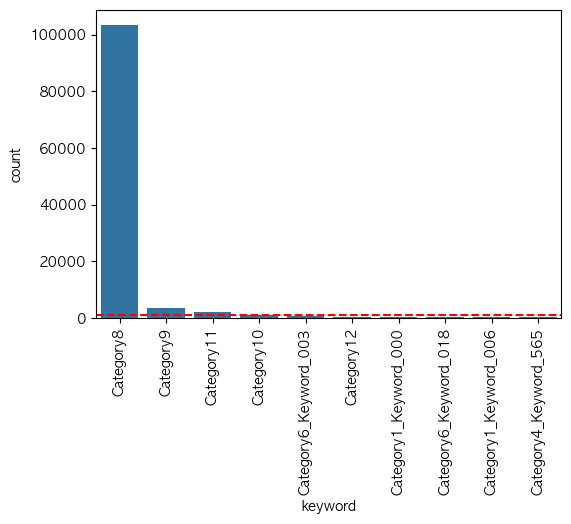

In [2404]:
# 'keyword' 별 빈도수 계산 및 상위 10개 추출
top_10_keywords = df['keyword'].value_counts().nlargest(10).index

# 상위 10개에 대한 시각화
plt.figure(figsize=(6, 4))
sns.countplot(x='keyword', data=df[df['keyword'].isin(top_10_keywords)], order=top_10_keywords)
plt.axhline(y=1000, color='r', linestyle='--')
plt.xticks(rotation=90)
plt.show()

In [2405]:
df[df['keyword']=='Category8']

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
0,SESSION_000000,USER_000000,17.0,Chrome,Macintosh,desktop,0,45.0,839.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
1,SESSION_000001,USER_000001,3.0,Chrome,Windows,desktop,1,1.0,39.0,0,0.0,0.0,Europe,Western Europe,Germany,google,organic,Category8,NaN
7,SESSION_000007,USER_000007,5.0,Chrome,Macintosh,desktop,1,1.0,64.0,0,0.0,0.0,Europe,Western Europe,Germany,google,organic,Category8,NaN
14,SESSION_000014,USER_000014,4.0,Chrome,Macintosh,desktop,1,2.0,34.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
17,SESSION_000017,USER_000017,1.0,Chrome,Android,mobile,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252273,SESSION_252273,USER_187872,1.0,Chrome,Macintosh,desktop,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
252278,SESSION_252278,USER_206016,2.0,Chrome,Android,mobile,1,1.0,32.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
252281,SESSION_252281,USER_206018,6.0,Chrome,Macintosh,desktop,1,1.0,99.0,0,0.0,0.0,Asia,Eastern Asia,Hong Kong,google,organic,Category8,NaN
252283,SESSION_252283,USER_206020,1.0,Chrome,Android,mobile,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN


In [2406]:
df[(df['keyword']=='Category8') & (df['browser']!='Chrome')]

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
20,SESSION_000020,USER_000020,3.0,Safari,iOS,mobile,1,1.0,41.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
23,SESSION_000023,USER_000023,10.0,Safari,iOS,mobile,0,13.0,208.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
25,SESSION_000025,USER_000025,11.0,Firefox,Windows,desktop,1,1.0,154.0,0,0.0,0.0,Europe,Eastern Europe,Bulgaria,google,organic,Category8,NaN
27,SESSION_000027,USER_000027,1.0,Safari,iOS,mobile,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
33,SESSION_000033,USER_000033,1.0,Firefox,Linux,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252232,SESSION_252232,USER_135438,2.0,Edge,Windows,desktop,0,2.0,147.0,0,0.0,0.0,Americas,Northern America,United States,bing,organic,Category8,NaN
252247,SESSION_252247,USER_205961,2.0,Safari,iOS,mobile,0,1.0,86.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
252256,SESSION_252256,USER_205999,2.0,Safari,iOS,mobile,1,1.0,21.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
252258,SESSION_252258,USER_206001,1.0,Safari,iOS,mobile,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN


In [2407]:
df[(df['keyword']=='Category8') & (df['traffic_source']!='google')]

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
46,SESSION_000046,USER_000046,1.0,Edge,Windows,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,bing,organic,Category8,NaN
390,SESSION_000390,USER_000375,5.0,Amazon Silk,Android,tablet,1,1.0,169.0,0,0.0,0.0,Americas,Northern America,United States,bing,organic,Category8,NaN
626,SESSION_000626,USER_000588,2.0,Edge,Windows,desktop,1,1.0,33.0,0,0.0,0.0,Europe,Western Europe,Germany,bing,organic,Category8,NaN
680,SESSION_000680,USER_000634,5.0,Safari,iOS,tablet,1,1.0,157.0,0,0.0,0.0,Americas,Northern America,United States,bing,organic,Category8,NaN
780,SESSION_000780,USER_000728,1.0,Internet Explorer,Windows,desktop,1,1.0,0.0,1,0.0,0.0,Asia,Southeast Asia,Indonesia,bing,organic,Category8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250779,SESSION_250779,USER_204909,1.0,Edge,Windows,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,bing,organic,Category8,NaN
251638,SESSION_251638,USER_135438,1.0,Edge,Windows,desktop,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,bing,organic,Category8,NaN
251956,SESSION_251956,USER_205780,7.0,Internet Explorer,Windows,desktop,1,2.0,99.0,0,0.0,0.0,Americas,Northern America,United States,yahoo,organic,Category8,NaN
252090,SESSION_252090,USER_205876,1.0,Safari,iOS,tablet,1,1.0,0.0,1,0.0,0.0,Oceania,Australasia,New Zealand,bing,organic,Category8,NaN


#### referral_path

In [2408]:
df['referral_path'].nunique()

1578

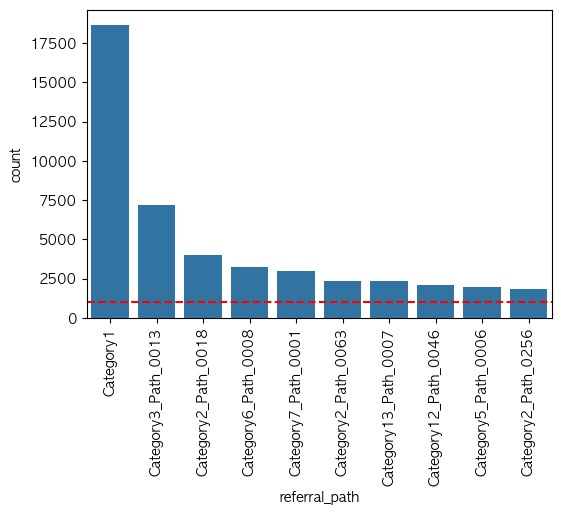

In [2409]:
# 'keyword' 별 빈도수 계산 및 상위 10개 추출
top_10_keywords = df['referral_path'].value_counts().nlargest(10).index

# 상위 10개에 대한 시각화
plt.figure(figsize=(6, 4))
sns.countplot(x='referral_path', data=df[df['referral_path'].isin(top_10_keywords)], order=top_10_keywords)
plt.axhline(y=1000, color='r', linestyle='--')
plt.xticks(rotation=90)
plt.show()

In [2410]:
df[df['referral_path']=='Category1']

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
35,SESSION_000035,USER_000035,3.0,Chrome,Macintosh,desktop,0,2.0,18.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
50,SESSION_000050,USER_000050,11.0,Chrome,Windows,desktop,1,23.0,160.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
56,SESSION_000056,USER_000056,4.0,Chrome,Chrome OS,desktop,0,1.0,45.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
111,SESSION_000111,USER_000109,1.0,Chrome,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
118,SESSION_000118,USER_000116,17.0,Chrome,Macintosh,desktop,1,64.0,1318.0,0,1.0,26620800.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252265,SESSION_252265,USER_144607,5.0,Chrome,Linux,desktop,0,1.0,37.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
252279,SESSION_252279,USER_206012,6.0,Chrome,Windows,desktop,0,3.0,25.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
252280,SESSION_252280,USER_206017,5.0,Chrome,Macintosh,desktop,1,1.0,67.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
252286,SESSION_252286,USER_164240,5.0,Chrome,Macintosh,desktop,0,2.0,69.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1


In [2411]:
df[df['referral_path']=='Category1']['traffic_source'].unique()

array(['(direct)', 'youtube.com', 'pinterest.com', 'l.facebook.com',
       'm.facebook.com', 'tw.search.yahoo.com', 'facebook.com',
       'duckduckgo.com', 'my.yahoo.com', 'au.search.yahoo.com',
       'in.search.yahoo.com', 'ph.search.yahoo.com',
       'es.search.yahoo.com', 'keep.google.com', 'ca.search.yahoo.com',
       'm.baidu.com', 'web.telegram.org', 'reddit.com',
       'uk.search.yahoo.com', 'outlook.live.com', 'getpocket.com',
       'youtube.thinkwithgoogle.com', 'se.search.yahoo.com',
       'us.search.yahoo.com', 'lm.facebook.com',
       'malaysia.search.yahoo.com', 'search.snapdo.com',
       'l.messenger.com', 'google.com', 'kik.com', 'images.google.com',
       'mail.yahoo.com', 'search.xfinity.com', 'plus.google.com',
       'startpage.com', 'web.whatsapp.com', 'nl.search.yahoo.com',
       'nl.pinterest.com', 'sites.google.com', 'google.co.uk',
       'it.search.yahoo.com', 'it.pinterest.com', 'images.google.com.br',
       'cz.pinterest.com', 'qc.search.yahoo.co

In [2412]:
df[df['referral_path']=='Category1']['traffic_medium'].unique()

array(['(none)', 'referral'], dtype=object)

In [2413]:
df[df['referral_path']=='Category1']['keyword'].unique()

array([nan], dtype=object)

### 3.2. 수치형 데이터 분석

In [2414]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252289 entries, 0 to 252288
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sessionID            252289 non-null  object 
 1   userID               252289 non-null  object 
 2   TARGET               252289 non-null  float64
 3   browser              252289 non-null  object 
 4   OS                   252289 non-null  object 
 5   device               252289 non-null  object 
 6   new                  252289 non-null  int64  
 7   quality              252289 non-null  float64
 8   duration             252289 non-null  float64
 9   bounced              252289 non-null  int64  
 10  transaction          252289 non-null  float64
 11  transaction_revenue  252289 non-null  float64
 12  continent            252289 non-null  object 
 13  subcontinent         252289 non-null  object 
 14  country              252289 non-null  object 
 15  traffic_source   

In [2415]:
df.describe()

,TARGET,new,quality,duration,bounced,transaction,transaction_revenue
count,252289.000000,252289.000000,252289.000000,252289.000000,252289.000000,252289.000000,2.522890e+05
mean,3.592626,0.751955,3.816805,113.104253,0.493672,0.009033,9.061248e+05
std,5.509465,0.431879,11.091028,330.876019,0.499961,0.100938,2.127689e+07
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000e+00
75%,4.000000,1.000000,1.000000,71.000000,1.000000,0.000000,0.000000e+00
max,386.000000,1.000000,98.000000,11186.000000,1.000000,12.000000,3.325712e+09


#### new

<Axes: xlabel='new', ylabel='Count'>

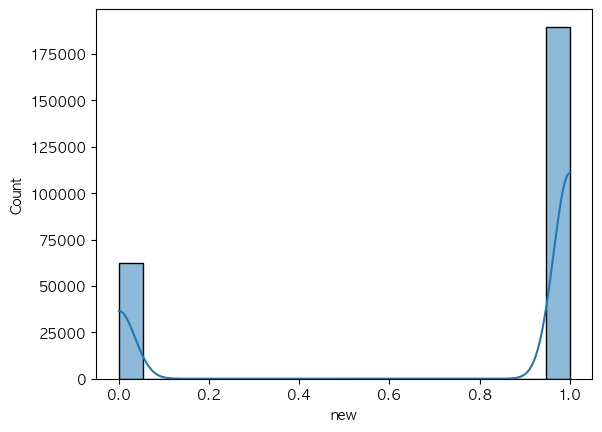

In [2416]:
sns.histplot(x='new', data=df, kde=True)

#### quality

<Axes: xlabel='quality', ylabel='Count'>

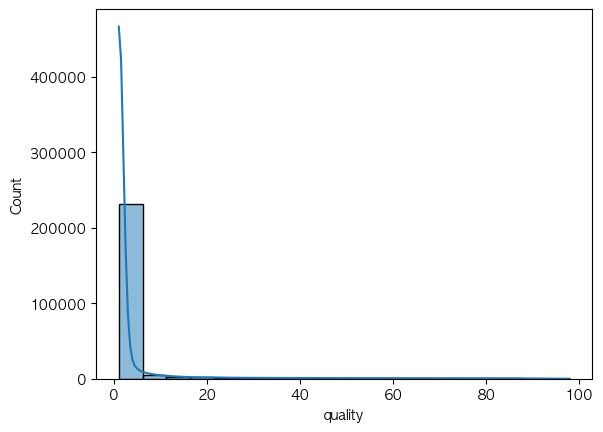

In [2417]:
sns.histplot(x='quality', data=df, kde=True)

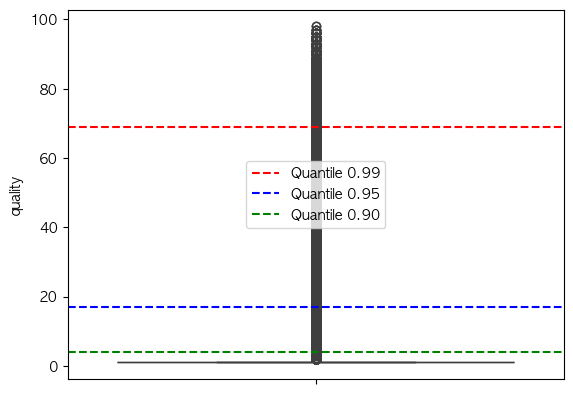

99% : 69.0 95% : 17.0 90% : 4.0


In [2418]:
sns.boxplot(y='quality', data=df)

# quantile(0.99), quantile(0.95), quantile(0.90) 계산
q99 = np.quantile(df['quality'], 0.99)
q95 = np.quantile(df['quality'], 0.95)
q90 = np.quantile(df['quality'], 0.90)
    
# 점선 추가
plt.axhline(y=q99, color='red', linestyle='--', label='Quantile 0.99')
plt.axhline(y=q95, color='blue', linestyle='--', label='Quantile 0.95')
plt.axhline(y=q90, color='green', linestyle='--', label='Quantile 0.90')
plt.legend(loc="center")

plt.show()

print('99% :', q99, '95% :', q95, '90% :', q90)

#### duration

<Axes: xlabel='duration', ylabel='Count'>

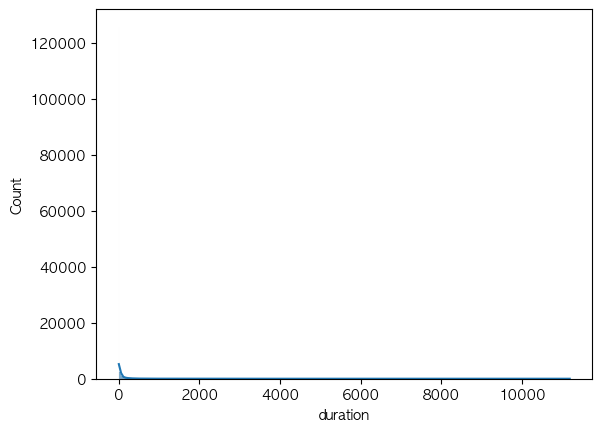

In [2419]:
sns.histplot(x='duration', data=df, kde=True)

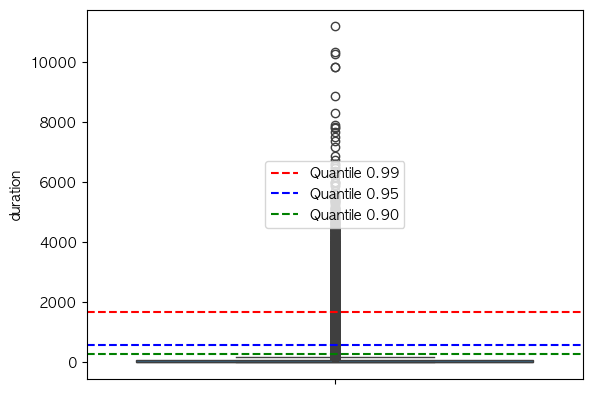

99% : 1686.1199999999953 95% : 589.5999999999767 90% : 271.0


In [2420]:
sns.boxplot(y='duration', data=df)

# quantile(0.99), quantile(0.95), quantile(0.90) 계산
q99 = np.quantile(df['duration'], 0.99)
q95 = np.quantile(df['duration'], 0.95)
q90 = np.quantile(df['duration'], 0.90)
    
# 점선 추가
plt.axhline(y=q99, color='red', linestyle='--', label='Quantile 0.99')
plt.axhline(y=q95, color='blue', linestyle='--', label='Quantile 0.95')
plt.axhline(y=q90, color='green', linestyle='--', label='Quantile 0.90')
plt.legend(loc="center")

plt.show()

print('99% :', q99, '95% :', q95, '90% :', q90)

#### bounced

<Axes: xlabel='bounced', ylabel='Count'>

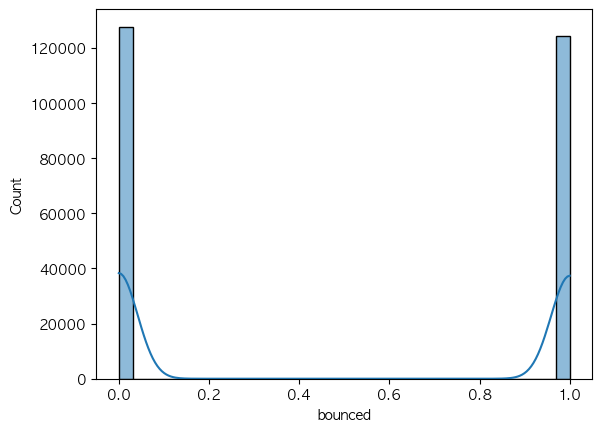

In [2421]:
sns.histplot(x='bounced', data=df, kde=True)

#### transaction

<Axes: xlabel='transaction', ylabel='Count'>

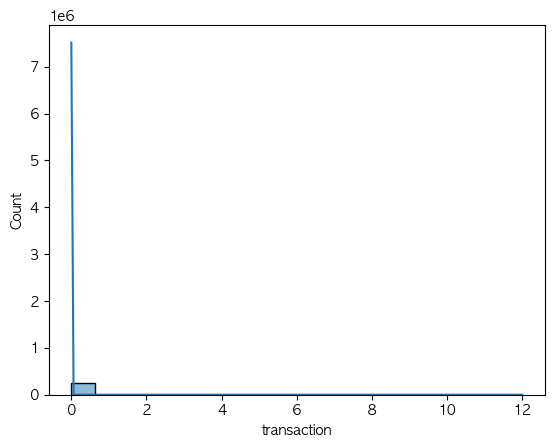

In [2422]:
sns.histplot(x='transaction', data=df, kde=True)

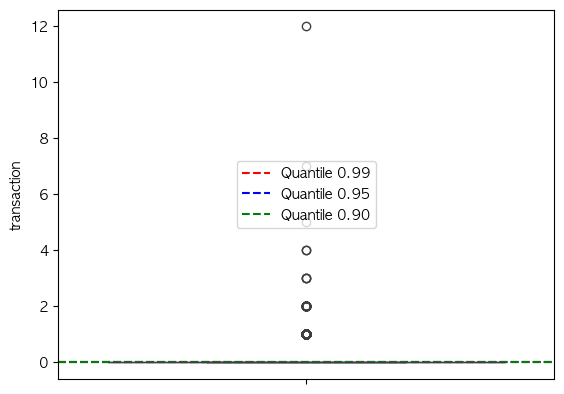

99% : 0.0 95% : 0.0 90% : 0.0


In [2423]:
sns.boxplot(y='transaction', data=df)

# quantile(0.99), quantile(0.95), quantile(0.90) 계산
q99 = np.quantile(df['transaction'], 0.99)
q95 = np.quantile(df['transaction'], 0.95)
q90 = np.quantile(df['transaction'], 0.90)
    
# 점선 추가
plt.axhline(y=q99, color='red', linestyle='--', label='Quantile 0.99')
plt.axhline(y=q95, color='blue', linestyle='--', label='Quantile 0.95')
plt.axhline(y=q90, color='green', linestyle='--', label='Quantile 0.90')
plt.legend(loc="center")

plt.show()

print('99% :', q99, '95% :', q95, '90% :', q90)

#### transaction_revenue

<Axes: xlabel='transaction_revenue', ylabel='Count'>

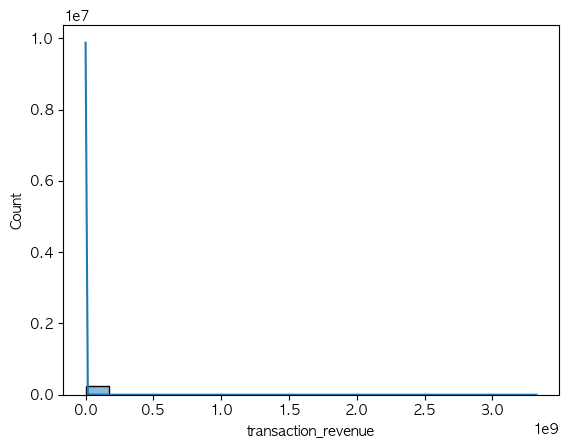

In [2424]:
sns.histplot(x='transaction_revenue', data=df, kde=True)

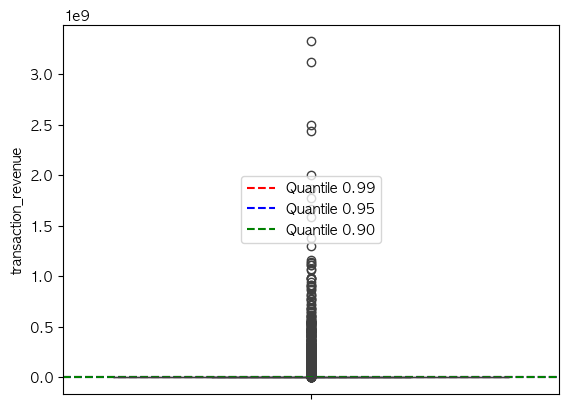

99% : 0.0 95% : 0.0 90% : 0.0


In [2425]:
sns.boxplot(y='transaction_revenue', data=df)

# quantile(0.99), quantile(0.95), quantile(0.90) 계산
q99 = np.quantile(df['transaction_revenue'], 0.99)
q95 = np.quantile(df['transaction_revenue'], 0.95)
q90 = np.quantile(df['transaction_revenue'], 0.90)
    
# 점선 추가
plt.axhline(y=q99, color='red', linestyle='--', label='Quantile 0.99')
plt.axhline(y=q95, color='blue', linestyle='--', label='Quantile 0.95')
plt.axhline(y=q90, color='green', linestyle='--', label='Quantile 0.90')
plt.legend(loc="center")

plt.show()

print('99% :', q99, '95% :', q95, '90% :', q90)

## 4. 데이터 전처리

### 4.1. 결측치 처리

In [2426]:
df.isna().sum()

sessionID                   0
userID                      0
TARGET                      0
browser                     0
OS                          0
device                      0
new                         0
quality                     0
duration                    0
bounced                     0
transaction                 0
transaction_revenue         0
continent                   0
subcontinent                0
country                     0
traffic_source              0
traffic_medium              0
keyword                137675
referral_path          161107
dtype: int64

In [2427]:
test.isna().sum()

sessionID                  0
userID                     0
browser                    0
OS                         0
device                     0
new                        0
quality                    0
duration                   0
bounced                    0
transaction                0
transaction_revenue        0
continent                  0
subcontinent               0
country                    0
traffic_source             0
traffic_medium             0
keyword                43070
referral_path          53891
dtype: int64

#### keyword, referral_path 결측치 처리

In [2428]:
df['keyword'].fillna('NaN', inplace=True)
df['referral_path'].fillna('NaN', inplace=True)

In [2429]:
test['keyword'].fillna('NaN', inplace=True)
test['referral_path'].fillna('NaN', inplace=True)

In [2430]:
df.isna().sum()

sessionID              0
userID                 0
TARGET                 0
browser                0
OS                     0
device                 0
new                    0
quality                0
duration               0
bounced                0
transaction            0
transaction_revenue    0
continent              0
subcontinent           0
country                0
traffic_source         0
traffic_medium         0
keyword                0
referral_path          0
dtype: int64

In [2431]:
test.isna().sum()

sessionID              0
userID                 0
browser                0
OS                     0
device                 0
new                    0
quality                0
duration               0
bounced                0
transaction            0
transaction_revenue    0
continent              0
subcontinent           0
country                0
traffic_source         0
traffic_medium         0
keyword                0
referral_path          0
dtype: int64

### 4.2. 파생변수 생성

In [2432]:
# # userID 중복 여부
# df['userID_duplicated'] = df.duplicated('userID', keep=False).astype(int)
# test['userID_duplicated'] = test['userID'].isin(df['userID']).astype(int)

### 4.3. 이상치 처리

In [2433]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in df.columns.drop("TARGET"):
    if pd.api.types.is_numeric_dtype(df[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("범주형 변수:", categorical_columns_v2)
print("연속형 변수:", continuous_columns_v2)

범주형 변수: ['sessionID', 'userID', 'browser', 'OS', 'device', 'continent', 'subcontinent', 'country', 'traffic_source', 'traffic_medium', 'keyword', 'referral_path']
연속형 변수: ['new', 'quality', 'duration', 'bounced', 'transaction', 'transaction_revenue']


In [2434]:
def remove_outliers(df, column_name):
    # 이상치를 제거할 데이터프레임 복사
    df_cleaned = df.copy()
    
    # IQR 계산
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    # 이상치 경계값 계산
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 이상치 제거
    df_cleaned = df_cleaned[(df_cleaned[column_name] >= lower_bound) & (df_cleaned[column_name] <= upper_bound)]
    
    return df_cleaned

In [2435]:
def remove_percentile_outliers(df, column_name, percentile):
    # 이상치를 제거할 데이터프레임 복사
    df_cleaned = df.copy()
    
    # 백분위수 이상을 제거
    threshold = df[column_name].quantile(percentile)
    df_cleaned = df_cleaned[df_cleaned[column_name] <= threshold]
    
    return df_cleaned

In [2436]:
# Target : 효과 없음...
# #df_cleaned = remove_outliers(df, 'TARGET')
# df_cleaned = remove_percentile_outliers(df, 'TARGET', 0.99)
# df = df_cleaned

In [2437]:
# grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
# print("이상치 제거 전 : ", df.shape[0])
# print(df['대출등급'].value_counts())

# # 수치형 : continuous_columns_v2 # 대출기간, 연체계좌수, 파생_총_상환_비율(총상환원금, 총상환이자, 대출금액), 파생_총_상환_비율_로그

# # 대출금액 : X

# # # 연간소득 : 0.99, 0.95, 0.90, IQR
# # df_cleaned_0 = pd.DataFrame()
# # for grade in grades:
# #     #df_grade_cleaned = remove_outliers(df[df['대출등급']==grade], '연간소득')
# #     df_grade_cleaned = remove_percentile_outliers(df[df['대출등급']==grade], '연간소득', 0.99)
# #     df_cleaned_0 = pd.concat([df_cleaned_0, df_grade_cleaned])
# # print("연간소득 이상치 제거 후 : ", df_cleaned_0.shape[0])
# # print(df_cleaned_0['대출등급'].value_counts())
# df_cleaned_0 = df

# # # 부채_대비_소득_비율 : 모두 IQR과 비슷
# # df_cleaned_1 = pd.DataFrame()
# # for grade in grades:
# #     df_grade_cleaned = remove_outliers(df_cleaned_0[df_cleaned_0['대출등급']==grade], '부채_대비_소득_비율')
# #     df_cleaned_1 = pd.concat([df_cleaned_1, df_grade_cleaned])
# # print("부채_대비_소득_비율 이상치 제거 후 : ", df_cleaned_1.shape[0])
# # print(df_cleaned_1['대출등급'].value_counts())
# df_cleaned_1 = df_cleaned_0

# # # 총계좌수 : 0.99, 0.95, 0.90, IQR
# # df_cleaned_2 = pd.DataFrame()
# # for grade in grades:
# #     #df_grade_cleaned = remove_outliers(df_cleaned_1[df_cleaned_1['대출등급']==grade], '총계좌수')
# #     df_grade_cleaned = remove_percentile_outliers(df_cleaned_1[df_cleaned_1['대출등급']==grade], '총계좌수', 0.99)
# #     df_cleaned_2 = pd.concat([df_cleaned_2, df_grade_cleaned])
# # print("총계좌수 이상치 제거 후 : ", df_cleaned_2.shape[0])
# # print(df_cleaned_2['대출등급'].value_counts())
# df_cleaned_2 = df_cleaned_1

# # # 최근_2년간_연체_횟수 : 모두 IQR과 비슷, 이상치를 제거할 경우, 값들이 모두 동일
# # df_cleaned_3 = pd.DataFrame()
# # for grade in grades:
# #     df_grade_cleaned = remove_outliers(df_cleaned_2[df_cleaned_2['대출등급']==grade], '최근_2년간_연체_횟수')
# #     df_cleaned_3 = pd.concat([df_cleaned_3, df_grade_cleaned])
# # print("최근_2년간_연체_횟수 이상치 제거 후 : ", df_cleaned_3.shape[0])
# # print(df_cleaned_3['대출등급'].value_counts())
# df_cleaned_3 = df_cleaned_2

# # 총상환원금 : 0.99, 0.95, 0.90, IQR(best)
# df_cleaned_4 = pd.DataFrame()
# for grade in grades:
#     df_grade_cleaned = remove_outliers(df_cleaned_3[df_cleaned_3['대출등급']==grade], '총상환원금')
#     #df_grade_cleaned = remove_percentile_outliers(df_cleaned_3[df_cleaned_3['대출등급']==grade], '총상환원금', 0.90)
#     df_cleaned_4 = pd.concat([df_cleaned_4, df_grade_cleaned])
# print("총상환원금 이상치 제거 후 : ", df_cleaned_4.shape[0])
# print(df_cleaned_4['대출등급'].value_counts())
# # df_cleaned_4 = df_cleaned_3

# # # 총상환이자 : 0.99, 0.95, 0.90, IQR, 안쓰는게 best
# # df_cleaned_5 = pd.DataFrame()
# # for grade in grades:
# #     df_grade_cleaned = remove_outliers(df_cleaned_4[df_cleaned_4['대출등급']==grade], '총상환이자')
# #     #df_grade_cleaned = remove_percentile_outliers(df_cleaned_4[df_cleaned_4['대출등급']==grade], '총상환이자', 0.90)
# #     df_cleaned_5 = pd.concat([df_cleaned_5, df_grade_cleaned])
# # print("총상환이자 이상치 제거 후 : ", df_cleaned_5.shape[0])
# # print(df_cleaned_5['대출등급'].value_counts())
# df_cleaned_5 = df_cleaned_4

# # # 총연체금액  : 모두 IQR과 비슷, 이상치를 제거할 경우, 값들이 모두 동일
# # df_cleaned_6 = pd.DataFrame()
# # for grade in grades:
# #     df_grade_cleaned = remove_outliers(df_cleaned_5[df_cleaned_5['대출등급']==grade], '총연체금액')
# #     df_cleaned_6 = pd.concat([df_cleaned_6, df_grade_cleaned])
# # print("총연체금액 이상치 제거 후 : ", df_cleaned_6.shape[0])
# # print(df_cleaned_6['대출등급'].value_counts())
# df_cleaned_6 = df_cleaned_5

# # # 연체계좌수 : 모두 IQR과 비슷, 이상치를 제거할 경우, 값들이 모두 동일
# # df_cleaned_7 = pd.DataFrame()
# # for grade in grades:
# #     df_grade_cleaned = remove_outliers(df_cleaned_6[df_cleaned_6['대출등급']==grade], '총연체금액')
# #     df_cleaned_7 = pd.concat([df_cleaned_7, df_grade_cleaned])
# # print("연체계좌수 이상치 제거 후 : ", df_cleaned_7.shape[0])
# # print(df_cleaned_7['대출등급'].value_counts())
# df_cleaned_7 = df_cleaned_6

# df_cleaned = df_cleaned_7
# #df_cleaned = df.copy()
# test_cleaned = test.copy()

# # 범주형 : categorical_columns_v2
# # 대출기간 : Ordinal 가능  : int로 변환
# df_cleaned['대출기간'] = df_cleaned['대출기간'].str[1:3].astype(int)
# test_cleaned['대출기간'] = test_cleaned['대출기간'].str[1:3].astype(int)

# # 근로기간 : Ordinal 가능 : int로 변환(Unknown일 경우 취업을 못했다 생각 -1로 매핑(다른 칼럼으로 추가할 수 있음, 10+ years일 경우 10으로 매핑했지만, 칼럼 추가 가능)
# mapping = {'Unknown': -1, '< 1 year': 0.5, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
#            '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}
# df_cleaned['근로기간'] = df_cleaned['근로기간'].map(mapping)
# test_cleaned['근로기간'] = test_cleaned['근로기간'].map(mapping)

# # 주택소유상태 : ANY 삭제
# df_cleaned.drop(df_cleaned[df_cleaned['주택소유상태'] == 'ANY'].index, inplace=True)
# print("주택소유상태 ANY 제거 후 : ", df_cleaned.shape[0])
# print(df_cleaned['대출등급'].value_counts())

# # # 대출목적 : onehot or column 줄이기 : 부채 통합 57%, 신용 카드 25%, 주택 개선 6%, 기타 5% -> 나머지를 기타로(주택 개선을 기타로 처리할지 말지 선택) 
# # df_cleaned['대출목적'] = df_cleaned['대출목적'].apply(lambda x: '기타' if x not in ['부채 통합', '신용 카드', '주택 개선'] else x)
# # test_cleaned['대출목적'] = test_cleaned['대출목적'].apply(lambda x: '기타' if x not in ['부채 통합', '신용 카드', '주택 개선'] else x)

### 4.4. 범주형 변수 처리

#### 라벨 인코딩

In [2438]:
# label_df = df.copy()
# label_test = test.copy()

# # 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# # 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
# label_encoders = {}

# categorical_columns = [col for col in categorical_columns_v2 if col != 'ID']

# # Implement Label Encoding
# for col in tqdm(categorical_columns):
#     lbl = LabelEncoder()

#     # Label-Encoding을 fit
#     lbl.fit(label_df[col].astype(str))
#     label_df[col] = lbl.transform(label_df[col].astype(str))
#     label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

#     # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
#     for label in np.unique(label_test[col]):
#       if label not in lbl.classes_: # unseen label 데이터인 경우
#         lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

#     label_test[col] = lbl.transform(label_test[col].astype(str))

In [2439]:
# display(label_df.head(1))
# display(label_test.head(1))
# print(label_df.shape, label_test.shape)

In [2440]:
# label_df.isna().sum()

In [2441]:
# label_test.isna().sum()

In [2442]:
# df = label_df
# test = label_test

#### 원-핫 인코딩

In [2443]:
# # 데이터프레임 복사
# onehot_df = df_cleaned.copy()
# onehot_test = test_cleaned.copy()

# # 범주형 변수를 원핫 인코딩할 열 선택 (id 열 제외)
# categorical_columns = [col for col in categorical_columns_v2 if col != 'ID']
# print(categorical_columns)

# # OneHotEncoder 객체 생성
# encoder = OneHotEncoder(handle_unknown='ignore')  # handle_unknown 매개변수를 'ignore'로 설정

# # 학습 데이터에 대해 원핫 인코딩 적용
# encoded_data = encoder.fit_transform(onehot_df[categorical_columns])

# # 인코딩된 데이터를 데이터프레임으로 변환
# encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(categorical_columns))

# # 원핫 인코딩된 결과를 원본 데이터프레임에 합침
# onehot_df = pd.concat([onehot_df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# # 학습 데이터에서 범주형 열 삭제
# onehot_df.drop(columns=categorical_columns, inplace=True)

# # 테스트 데이터에 대해 원핫 인코딩 적용
# encoded_test_data = encoder.transform(onehot_test[categorical_columns])
# encoded_test_df = pd.DataFrame(encoded_test_data.toarray(), columns=encoder.get_feature_names_out(categorical_columns))

# # 원핫 인코딩된 결과를 원본 테스트 데이터프레임에 합침
# onehot_test = pd.concat([onehot_test, encoded_test_df], axis=1)

# # 테스트 데이터에서 범주형 열 삭제
# onehot_test.drop(columns=categorical_columns, inplace=True)

In [2444]:
# display(onehot_df.head(1))
# display(onehot_test.head(1))
# print(onehot_df.shape, onehot_test.shape)

In [2445]:
# onehot_df.isna().sum()

In [2446]:
# onehot_test.isna().sum()

In [2447]:
# df = onehot_df
# test = onehot_test

### 4.5. 추가 결측치 처리

In [2448]:
df.isna().sum()

sessionID              0
userID                 0
TARGET                 0
browser                0
OS                     0
device                 0
new                    0
quality                0
duration               0
bounced                0
transaction            0
transaction_revenue    0
continent              0
subcontinent           0
country                0
traffic_source         0
traffic_medium         0
keyword                0
referral_path          0
dtype: int64

In [2449]:
test.isna().sum()

sessionID              0
userID                 0
browser                0
OS                     0
device                 0
new                    0
quality                0
duration               0
bounced                0
transaction            0
transaction_revenue    0
continent              0
subcontinent           0
country                0
traffic_source         0
traffic_medium         0
keyword                0
referral_path          0
dtype: int64

### 4.6. 스케일링

In [2450]:
# scaler = StandardScaler()
# #scaler = MinMaxScaler()
# #scaler = RobustScaler()
# #scaler = MaxAbsScaler()

# # ID와 대출등급 컬럼을 제외하고 스케일링
# #columns_to_scale = df.columns.drop(['sessionID', 'userID', 'TARGET'])
# columns_to_scale = ["TARGET"]
# df_scaled = scaler.fit_transform(df[columns_to_scale])
# df['TARGET'] = df_scaled

# # # 스케일된 데이터를 DataFrame으로 변환하고, ID와 대출등급 컬럼을 다시 추가
# # df_scaled = pd.DataFrame(df_scaled, columns=columns_to_scale)
# # df_scaled['ID'] = df['ID']
# # df_scaled['대출등급'] = df['대출등급']

# # # 테스트 데이터에 대해서도 동일하게 적용
# # test_scaled = scaler.fit_transform(test[columns_to_scale])
# # test_scaled = pd.DataFrame(test_scaled, columns=columns_to_scale)
# # test_scaled['ID'] = test['ID']

# # df = df_scaled
# # test = test_scaled

In [2451]:
# # 타켓 log1p 변환
# df['TARGET'] = np.log1p(df['TARGET']) 

## 5. 상관관계 분석 및 feature selection

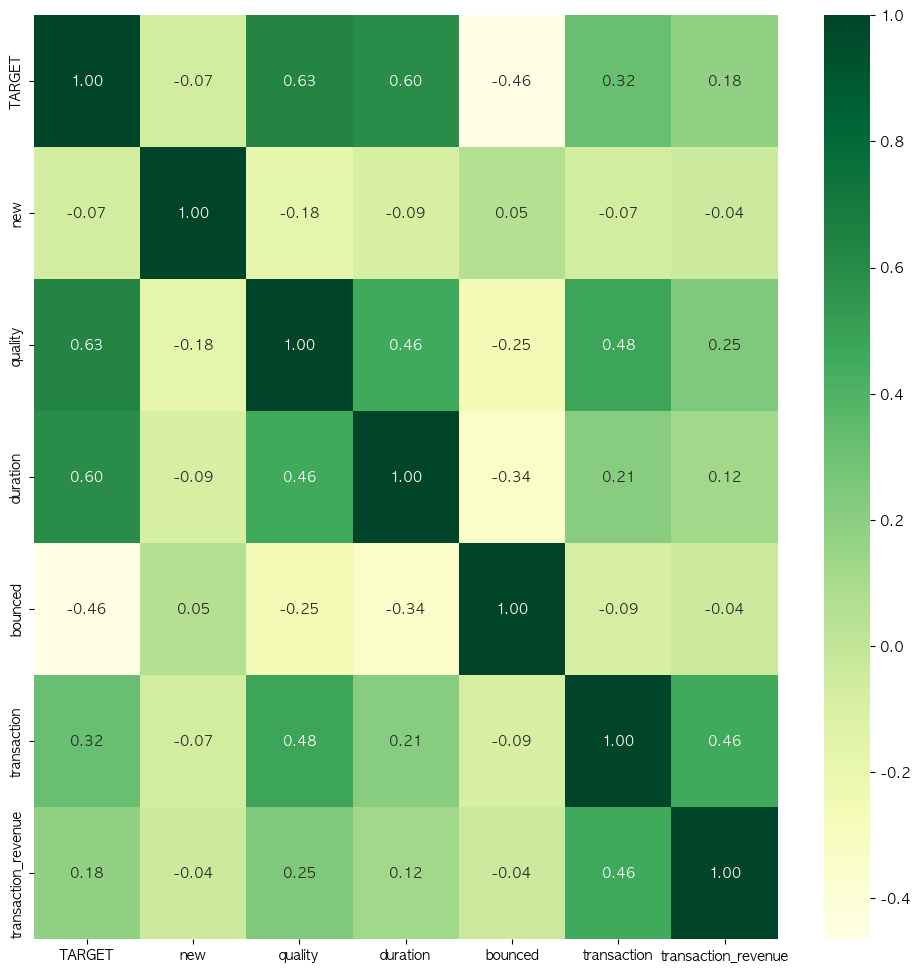

In [2452]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGn', fmt='.2f')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

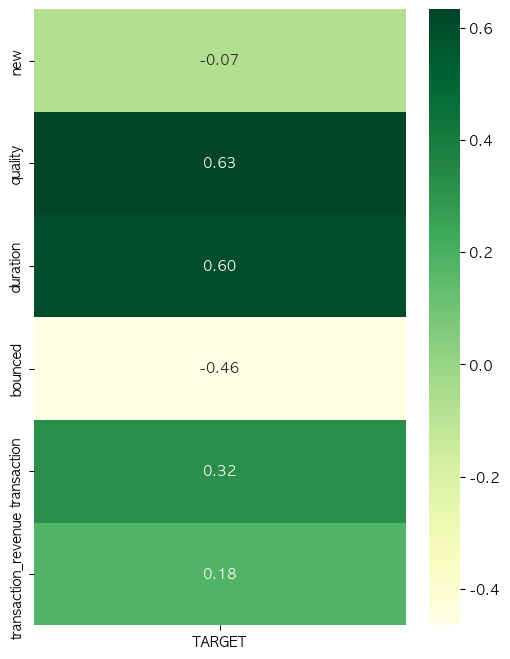

In [2453]:
target_corr = correlation_matrix['TARGET'].drop('TARGET')
plt.figure(figsize=(6,8))
sns.heatmap(pd.DataFrame(target_corr), annot=True, cmap='YlGn', fmt='.2f')
plt.show

In [2454]:
# selected_col = ['TARGET', 'sessionID', 'quality', 'duration', 'subcontinent', 'traffic_source', 'OS', 'new', 'browser', 'transaction', 'referral_path', 'country', 'transaction_revenue', 'userID']
# # selected_col = selected_col = ['TARGET', 'sessionID', 'quality', 'duration', 'bounced', 'transaction']
# df = df[selected_col]
# test = test[selected_col[1:]]

In [2455]:
drop_col = ['transaction_revenue', 'device']
df = df.drop(columns=drop_col)
test = test.drop(columns=drop_col)

In [2456]:
# # TARGET 값이 100 이하인 데이터만 필터링
# df = df[df['TARGET'] <= 250]

## 6. 데이터 Split

In [2457]:
# 분할된 데이터를 fold별로 시각화하기 위한 함수를 구성합니다.
# Scikit-learn에서 https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html 사용한 코드를 가져와서 사용하겠습니다.
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(x, y, cv, ax, split_strategy='KFold', group=None, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    for ii, (tr, tt) in enumerate(cv.split(X=x, y=y, groups=group)):
        # Fill in indices with the training/test groups
        print(f"Fold {ii} :")
        print(f"  Train : index={tr[:5]}...")
        print(f"  Valid : index={tt[:5]}...")
        indices = np.array([np.nan] * len(x))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=0.2,
        )

    # Formatting
    yticklabels = list(range(5))

    ax.set(
        yticks=np.arange(len(yticklabels)) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[len(yticklabels) + 0.2, -0.2],
        xlim=[0, len(x)],
    )
    ax.set_title(split_strategy, fontsize=15)
    return ax

### 6.1. Holdout

In [2458]:
X = df.drop(columns=['sessionID', 'TARGET']) # sessionID는 1개 씩 밖에 없음
y = df['TARGET']

print(X.shape, y.shape)

(252289, 15) (252289,)


In [2459]:
# train_test_split() 함수로 학습 데이터와 테스트 데이터 분리하기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42, shuffle=True)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(239674, 15) (239674,)
(12615, 15) (12615,)


In [2460]:
# # 동일한 과정을 statsmodel 패키지로 사용해보겠습니다. 조금 더 디테일한 결과를 얻을 수 있습니다.
# # 모델 적합 결과는 sklearn과 동일함을 알 수 있습니다.
# import statsmodels.api as sm

# # 훈련 데이터에 상수항 추가
# X_train_with_const = sm.add_constant(X_train)
# model = sm.OLS(y_train, X_train_with_const)

# # model = sm.OLS(y_train, X_train)
# result = model.fit()
# print(result.summary())

### 6.2. K-Fold

In [2461]:
# DataFrame을 랜덤하게 섞고 인덱스 초기화
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [2462]:
X = df.drop(columns=['sessionID', 'TARGET']) # sessionID는 1개 씩 밖에 없음
y = df['TARGET']

print(X.shape, y.shape)

(252289, 15) (252289,)


In [2463]:
# train_test_split() 함수로 학습 데이터와 테스트 데이터 분리하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# # # 전체 데이터 사용
# # X_train = X
# # y_train = y

(227060, 15) (227060,)
(25229, 15) (25229,)


In [2464]:
# # Kfold 함수를 선언합니다.
# kf = KFold(n_splits=5)
kf = KFold(n_splits=10)

Fold 0 :
  Train : index=[22706 22707 22708 22709 22710]...
  Valid : index=[0 1 2 3 4]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[22706 22707 22708 22709 22710]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[45412 45413 45414 45415 45416]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[68118 68119 68120 68121 68122]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[90824 90825 90826 90827 90828]...
Fold 5 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[113530 113531 113532 113533 113534]...
Fold 6 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[136236 136237 136238 136239 136240]...
Fold 7 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[158942 158943 158944 158945 158946]...
Fold 8 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[181648 181649 181650 181651 181652]...
Fold 9 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[204354 204355 204356 204357 204358]...


<Axes: title={'center': 'K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

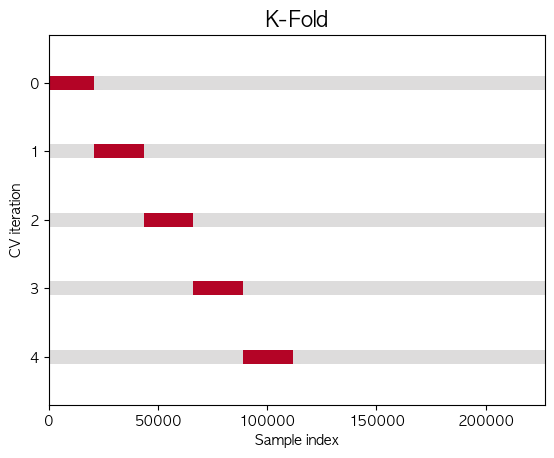

In [2465]:
# kfold를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train,
                y=y_train,
                cv=kf,
                ax=ax,
                split_strategy='K-Fold')

In [2466]:
# 학습 데이터를 Kfold로 나눕니다.
train_folds = kf.split(X_train, y_train)

### 6.3. Group K-Fold

In [1295]:
# # DataFrame을 랜덤하게 섞고 인덱스 초기화
# df = df.sample(frac=1).reset_index(drop=True)

In [1296]:
# X = df.drop(columns=['ID', '대출등급']) # ID는 1개 씩 밖에 없음
# y = df['대출등급']

# print(X.shape, y.shape)

In [1297]:
# # train_test_split() 함수로 학습 데이터와 테스트 데이터 분리하기
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, shuffle=True)

# print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)

# # 전체 데이터 사용
# X_train = X
# y_train = y

In [1298]:
# # col을 Group을 나누는 기준으로 사용합니다.
# col = ''
# groups = list(X_train[col].astype('int'))

In [1299]:
# # GroupKfold 함수를 선언합니다.
# kf = GroupKFold(n_splits=df[col].nunique())

In [1300]:
# # GroupKfold를 시각화합니다.
# fig, ax = plt.subplots()
# plot_cv_indices(x=X_train.sort_values(by=col),
#                 y=y_train,
#                 cv=kf,
#                 group=groups,
#                 ax=ax,
#                 split_strategy='Code Group K-Fold')

In [1301]:
# # 학습 데이터를 GroupKfold로 나눕니다.
# train_folds = kf.split(X_train, y_train, groups=groups)

## 7. 모델 훈련

### 7.1. CatBoost

#### Hold Out

In [1523]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in df.columns.drop("TARGET"):
    if pd.api.types.is_numeric_dtype(df[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("범주형 변수:", categorical_columns_v2)
print("연속형 변수:", continuous_columns_v2)

범주형 변수: ['sessionID', 'userID', 'browser', 'OS', 'device', 'continent', 'subcontinent', 'country', 'traffic_source', 'traffic_medium', 'keyword', 'referral_path']
연속형 변수: ['new', 'quality', 'duration', 'bounced', 'transaction', 'transaction_revenue']


In [1524]:
# %%time
# model = CatBoostRegressor(iterations=10000, random_state=42, loss_function='RMSE', learning_rate=0.001)
# model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=categorical_columns_v2[1:], verbose=10)
# pred = model.predict(X_val)
# best_model = model

In [1525]:
# #%%time
# model = CatBoostRegressor(iterations=10000, random_state=42, loss_function='RMSE', learning_rate=0.001)
# model.fit(X_train, y_train, eval_set=(X_val, y_val),
#           early_stopping_rounds=100, cat_features=categorical_columns_v2[1:], verbose=10)
# pred = model.predict(X_val)
# best_model = model

In [1526]:
#%%time
model = CatBoostRegressor(random_state=42)
model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=categorical_columns_v2[1:])
pred = model.predict(X_val)
best_model = model

Learning rate set to 0.120364
0:	learn: 0.0133095	test: 0.0124882	best: 0.0124882 (0)	total: 135ms	remaining: 2m 14s
1:	learn: 0.0124355	test: 0.0115570	best: 0.0115570 (1)	total: 267ms	remaining: 2m 13s
2:	learn: 0.0116966	test: 0.0107618	best: 0.0107618 (2)	total: 395ms	remaining: 2m 11s
3:	learn: 0.0110488	test: 0.0100712	best: 0.0100712 (3)	total: 518ms	remaining: 2m 9s
4:	learn: 0.0105232	test: 0.0095135	best: 0.0095135 (4)	total: 624ms	remaining: 2m 4s
5:	learn: 0.0100966	test: 0.0090565	best: 0.0090565 (5)	total: 737ms	remaining: 2m 2s
6:	learn: 0.0097083	test: 0.0086342	best: 0.0086342 (6)	total: 847ms	remaining: 2m
7:	learn: 0.0093760	test: 0.0082778	best: 0.0082778 (7)	total: 949ms	remaining: 1m 57s
8:	learn: 0.0091009	test: 0.0079753	best: 0.0079753 (8)	total: 1.06s	remaining: 1m 56s
9:	learn: 0.0088653	test: 0.0077133	best: 0.0077133 (9)	total: 1.18s	remaining: 1m 56s
10:	learn: 0.0086745	test: 0.0074961	best: 0.0074961 (10)	total: 1.29s	remaining: 1m 55s
11:	learn: 0.00850

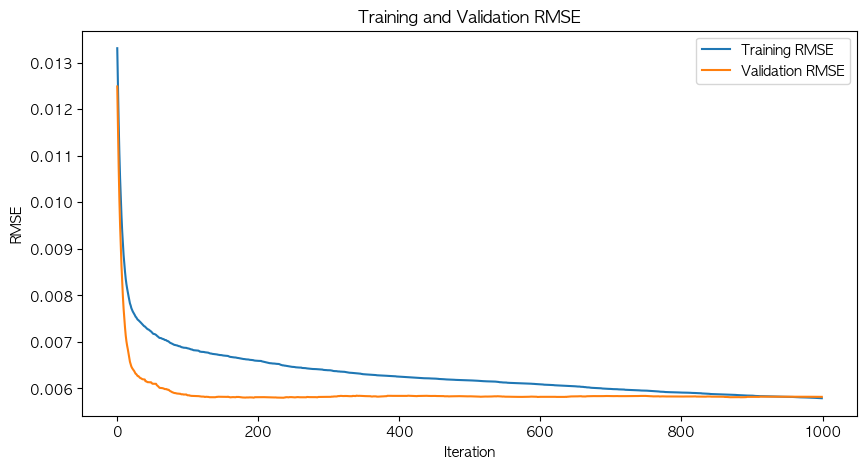

In [1527]:
results = model.get_evals_result()

# 훈련 및 검증 데이터셋에 대한 RMSE 그리기
plt.figure(figsize=(10, 5))
plt.plot(results['learn']['RMSE'], label='Training RMSE')
plt.plot(results['validation']['RMSE'], label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()

In [1528]:
# MAE 계산
mae = mean_absolute_error(y_val, pred)
print(f"Mean Absolute Error: {mae}")

# MSE 계산
mse = mean_squared_error(y_val, pred)
print(f"Mean Squared Error: {mse}")

# RMSE 계산
rmse = mean_squared_error(y_val, pred, squared=False)
print(f"Root Mean Squared Error: {rmse}")

# R-squared 계산
r2 = r2_score(y_val, pred)
print(f"R-squared: {r2}")

Mean Absolute Error: 0.0022748324845290172
Mean Squared Error: 3.3658761796028984e-05
Root Mean Squared Error: 0.005801617170757563
R-squared: 0.8180056088782015


전체 8:2

- Mean Absolute Error: 0.8754373418481756
- Mean Squared Error: 6.058834776882118
- Root Mean Squared Error: 2.4614700438725876
- R-squared: 0.7909041531492668

전체 9.5:0.5
- Mean Absolute Error: 0.8718172686754615
- Mean Squared Error: 5.166435153411638
- Root Mean Squared Error: 2.272979356134067
- R-squared: 0.811535571520554

전체 9.5:0.5 & earlystopping(전체 칼럼)
- Mean Absolute Error: 0.8858588839602954
- Mean Squared Error: 5.050814550885471
- Root Mean Squared Error: 2.2474017333101513
- R-squared: 0.8157532516285011

In [1308]:
# # MAE 계산
# mae = mean_absolute_error(np.expm1(y_val), np.expm1(pred))
# print(f"Mean Absolute Error: {mae}")

# # MSE 계산
# mse = mean_squared_error(np.expm1(y_val), np.expm1(pred))
# print(f"Mean Squared Error: {mse}")

# # RMSE 계산
# rmse = mean_squared_error(np.expm1(y_val), np.expm1(pred), squared=False)
# print(f"Root Mean Squared Error: {rmse}")

# # R-squared 계산
# r2 = r2_score(np.expm1(y_val), np.expm1(pred))
# print(f"R-squared: {r2}")

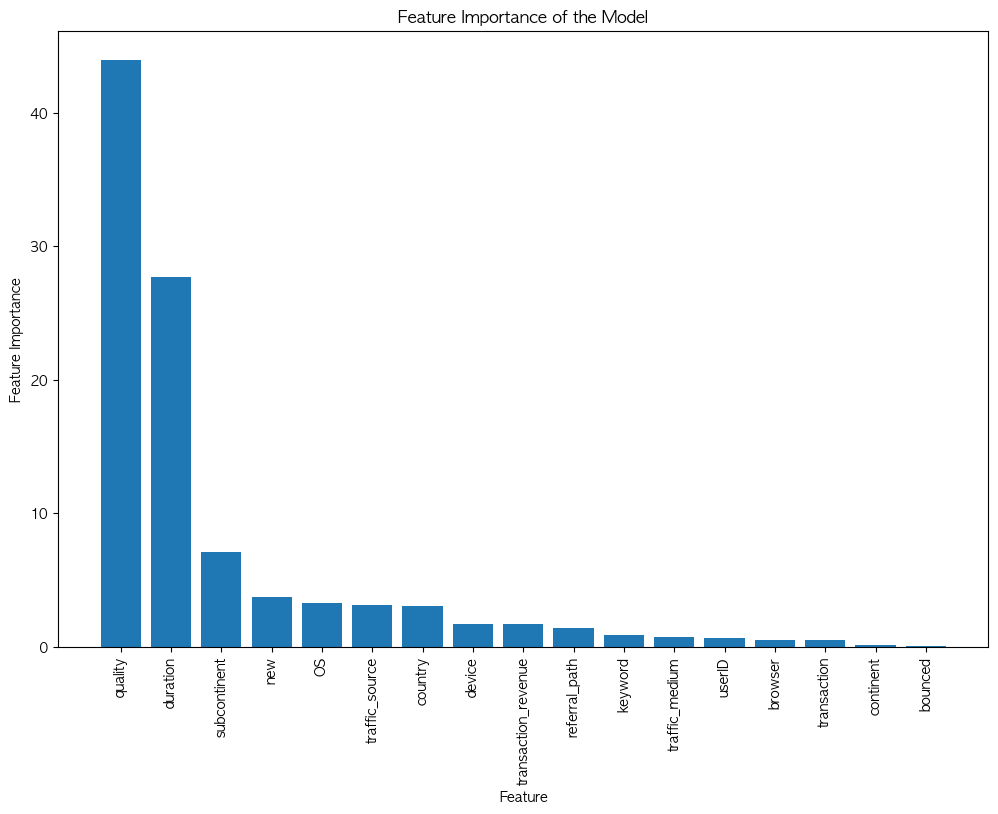

In [1309]:
# 모델의 feature 중요도
feature_importance = model.feature_importances_

# feature 이름 (열 이름)
feature_names = X_train.columns

# 중요도를 내림차순으로 정렬
sorted_idx = feature_importance.argsort()[::-1]

# 가장 중요한 feature 순으로 정렬된 feature 중요도를 그래프로 표시
plt.figure(figsize=(12, 8))
plt.bar(range(len(feature_names)), feature_importance[sorted_idx], align="center")
plt.xticks(range(len(feature_names)), feature_names[sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Feature Importance of the Model")
plt.show()

(quality, duration), subcontinent, country, new, OS, traffic_source, browser, device, userID, transaction_revenue, referral_path, transaction, keyword, traffic_medium, continent, bounced

In [ ]:
# # Permutation importance
# perm = PermutationImportance(model,
#                              scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
#                              random_state = 42,
#                              n_iter=5).fit(X_val, y_val)

# eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

#### KFold

In [2467]:
# 학습 데이터를 Kfold로 나눕니다.
train_folds = kf.split(X_train, y_train)
display(train_folds)

<generator object _BaseKFold.split at 0x7ff2097ad8c0>

In [2468]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in df.columns.drop("TARGET"):
    if pd.api.types.is_numeric_dtype(df[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("범주형 변수:", categorical_columns_v2)
print("연속형 변수:", continuous_columns_v2)

범주형 변수: ['sessionID', 'userID', 'browser', 'OS', 'continent', 'subcontinent', 'country', 'traffic_source', 'traffic_medium', 'keyword', 'referral_path']
연속형 변수: ['new', 'quality', 'duration', 'bounced', 'transaction']


--------0번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.028815
0:	learn: 5.4525661	test: 5.3011864	best: 5.3011864 (0)	total: 132ms	remaining: 22m 4s
100:	learn: 2.9730818	test: 2.7491709	best: 2.7491709 (100)	total: 9.41s	remaining: 15m 22s
200:	learn: 2.8558893	test: 2.6611131	best: 2.6608472 (198)	total: 17.2s	remaining: 13m 57s
300:	learn: 2.7901242	test: 2.6176566	best: 2.6176565 (299)	total: 24.6s	remaining: 13m 12s
400:	learn: 2.7340502	test: 2.5802356	best: 2.5802356 (400)	total: 32.8s	remaining: 13m 5s
500:	learn: 2.6958526	test: 2.5638563	best: 2.5637779 (497)	total: 41.7s	remaining: 13m 10s
600:	learn: 2.6595519	test: 2.5529773	best: 2.5529773 (600)	total: 51.8s	remaining: 13m 30s
700:	learn: 2.6251052	test: 2.5537484	best: 2.5512850 (641)	total: 1m 1s	remaining: 13m 35s
800:	learn: 2.5993467	test: 2.5516704	best: 2.5503357 (731)	total: 1m 11s	remaining: 13m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.550335721
bestIteration = 731

Shrink mod

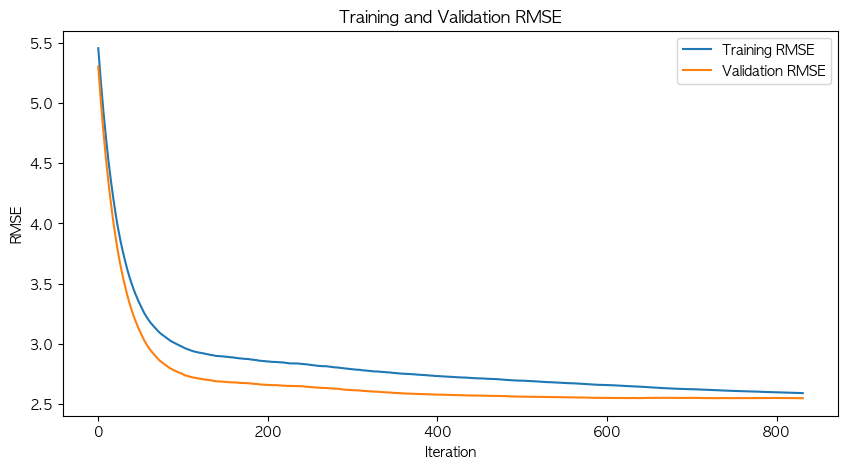

0번째 fold - MAE: 0.8780767773317395, MSE: 6.497775283055108, RMSE: 2.5490734165682847, R-squared: 0.7771810826684367
--------0번째 fold는 kfold0_cat.pkl에 저장되었습니다.--------


--------1번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.028815
0:	learn: 5.4629775	test: 5.2040948	best: 5.2040948 (0)	total: 128ms	remaining: 21m 21s
100:	learn: 2.9799621	test: 2.5639547	best: 2.5639547 (100)	total: 10.5s	remaining: 17m 6s
200:	learn: 2.8566410	test: 2.4683600	best: 2.4683600 (200)	total: 19.2s	remaining: 15m 34s
300:	learn: 2.7959526	test: 2.4246696	best: 2.4246696 (300)	total: 27.9s	remaining: 14m 59s
400:	learn: 2.7405605	test: 2.3967422	best: 2.3967422 (400)	total: 37.2s	remaining: 14m 51s
500:	learn: 2.6926135	test: 2.3780700	best: 2.3779973 (499)	total: 47.1s	remaining: 14m 52s
600:	learn: 2.6564965	test: 2.3693318	best: 2.3692665 (599)	total: 57.4s	remaining: 14m 57s
700:	learn: 2.6269326	test: 2.3628111	best: 2.3626749 (693)	total: 1m 7s	remaining: 14m 57s
800:	learn: 2.6019320	test: 2.359

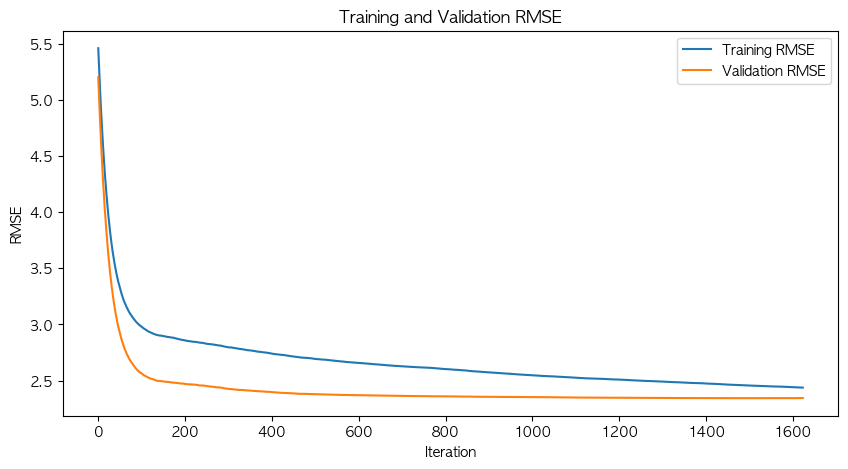

1번째 fold - MAE: 0.869044926444762, MSE: 5.4822384872506635, RMSE: 2.341418050509277, R-squared: 0.8052746857473829
--------1번째 fold는 kfold1_cat.pkl에 저장되었습니다.--------


--------2번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.028815
0:	learn: 5.4469501	test: 5.3458272	best: 5.3458272 (0)	total: 112ms	remaining: 18m 41s
100:	learn: 2.9471499	test: 2.9289913	best: 2.9289913 (100)	total: 10.3s	remaining: 16m 47s
200:	learn: 2.8283444	test: 2.8590565	best: 2.8581997 (198)	total: 18.7s	remaining: 15m 11s
300:	learn: 2.7700180	test: 2.8230699	best: 2.8230699 (300)	total: 27.5s	remaining: 14m 47s
400:	learn: 2.7147008	test: 2.7906291	best: 2.7905835 (398)	total: 37.2s	remaining: 14m 50s
500:	learn: 2.6783829	test: 2.7766062	best: 2.7762319 (486)	total: 47.3s	remaining: 14m 55s
600:	learn: 2.6489010	test: 2.7684414	best: 2.7684414 (600)	total: 56.9s	remaining: 14m 49s
700:	learn: 2.6178874	test: 2.7545930	best: 2.7545930 (700)	total: 1m 6s	remaining: 14m 41s
800:	learn: 2.5924696	test: 2.745

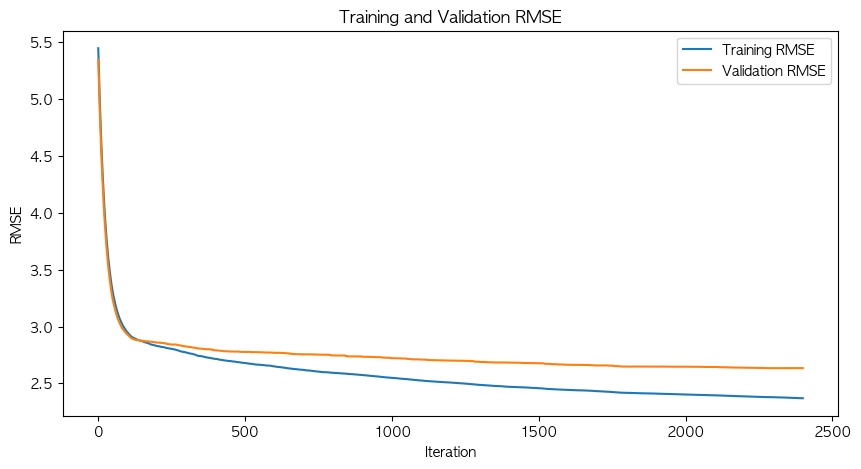

2번째 fold - MAE: 0.8555605032440435, MSE: 6.932212099924683, RMSE: 2.6329094363317327, R-squared: 0.7660036506383883
--------2번째 fold는 kfold2_cat.pkl에 저장되었습니다.--------


--------3번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.028815
0:	learn: 5.4581342	test: 5.2497410	best: 5.2497410 (0)	total: 117ms	remaining: 19m 28s
100:	learn: 2.9834998	test: 2.5712012	best: 2.5712012 (100)	total: 10.8s	remaining: 17m 35s
200:	learn: 2.8300799	test: 2.4699685	best: 2.4699685 (200)	total: 20.9s	remaining: 16m 57s
300:	learn: 2.7484464	test: 2.4309638	best: 2.4309638 (300)	total: 31.2s	remaining: 16m 45s
400:	learn: 2.6999703	test: 2.4133554	best: 2.4133554 (400)	total: 41.5s	remaining: 16m 33s
500:	learn: 2.6578912	test: 2.4044347	best: 2.4041396 (498)	total: 51.6s	remaining: 16m 18s
600:	learn: 2.6195343	test: 2.3965869	best: 2.3965869 (600)	total: 1m 1s	remaining: 16m 1s
700:	learn: 2.5906682	test: 2.3887618	best: 2.3884188 (697)	total: 1m 11s	remaining: 15m 46s
800:	learn: 2.5652570	test: 2.38

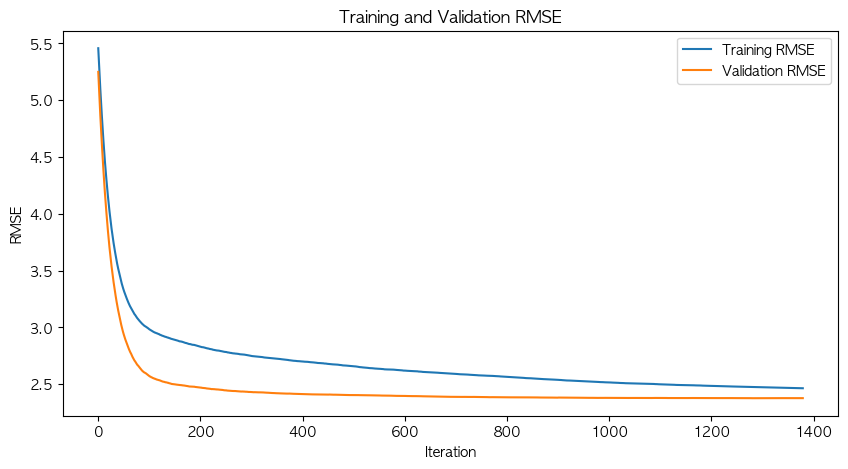

3번째 fold - MAE: 0.8724041393459482, MSE: 5.645892082900073, RMSE: 2.376108600821956, R-squared: 0.8028497174155134
--------3번째 fold는 kfold3_cat.pkl에 저장되었습니다.--------


--------4번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.028815
0:	learn: 5.4540975	test: 5.2920667	best: 5.2920667 (0)	total: 110ms	remaining: 18m 16s
100:	learn: 2.9779530	test: 2.7114129	best: 2.7114129 (100)	total: 10.1s	remaining: 16m 34s
200:	learn: 2.8571800	test: 2.5983877	best: 2.5983877 (200)	total: 19s	remaining: 15m 26s
300:	learn: 2.7852385	test: 2.5370942	best: 2.5370942 (300)	total: 28.1s	remaining: 15m 4s
400:	learn: 2.7254676	test: 2.4965790	best: 2.4965790 (400)	total: 37.3s	remaining: 14m 54s
500:	learn: 2.6894050	test: 2.4752414	best: 2.4752414 (500)	total: 47s	remaining: 14m 50s
600:	learn: 2.6612209	test: 2.4602282	best: 2.4602282 (600)	total: 56.7s	remaining: 14m 46s
700:	learn: 2.6294319	test: 2.4488707	best: 2.4488707 (700)	total: 1m 6s	remaining: 14m 39s
800:	learn: 2.6015644	test: 2.4394050	

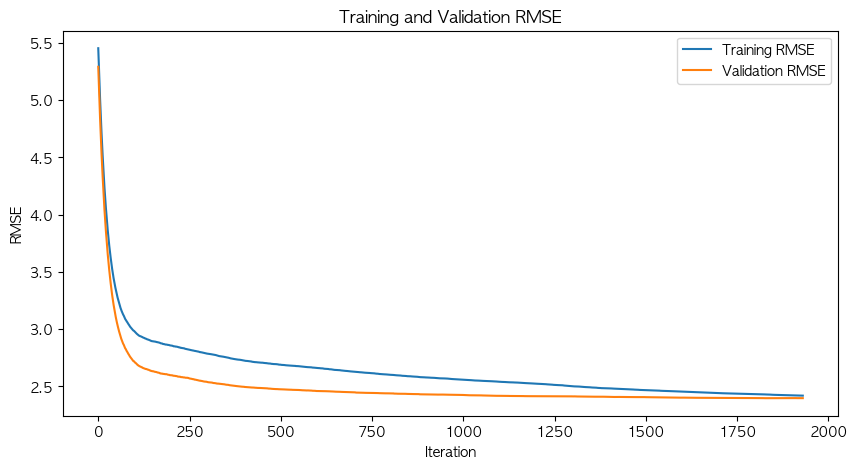

4번째 fold - MAE: 0.8686012993642612, MSE: 5.74214535130358, RMSE: 2.3962773944816114, R-squared: 0.8023194730085658
--------4번째 fold는 kfold4_cat.pkl에 저장되었습니다.--------


--------5번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.028815
0:	learn: 5.4148053	test: 5.6441982	best: 5.6441982 (0)	total: 124ms	remaining: 20m 36s
100:	learn: 2.9110822	test: 3.1883564	best: 3.1883564 (100)	total: 10.5s	remaining: 17m 6s
200:	learn: 2.7938838	test: 3.0986918	best: 3.0986918 (200)	total: 19.9s	remaining: 16m 12s
300:	learn: 2.7422823	test: 3.0689370	best: 3.0689370 (300)	total: 29.4s	remaining: 15m 46s
400:	learn: 2.7018922	test: 3.0451118	best: 3.0450777 (398)	total: 38.8s	remaining: 15m 28s
500:	learn: 2.6668484	test: 3.0287789	best: 3.0287789 (500)	total: 49.3s	remaining: 15m 34s
600:	learn: 2.6272094	test: 3.0144407	best: 3.0144407 (600)	total: 59.3s	remaining: 15m 27s
700:	learn: 2.6059978	test: 3.0095850	best: 3.0092524 (682)	total: 1m 9s	remaining: 15m 22s
800:	learn: 2.5839535	test: 2.9984

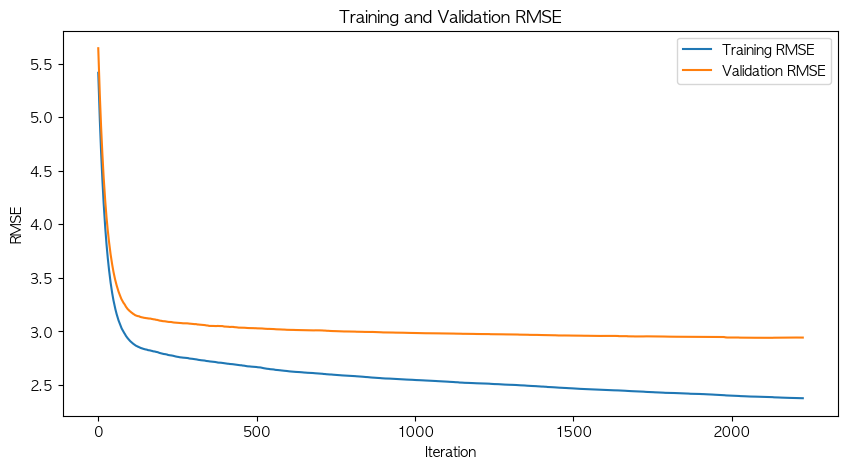

5번째 fold - MAE: 0.8922413596243747, MSE: 8.640811729337997, RMSE: 2.9395257660612533, R-squared: 0.7376822532783156
--------5번째 fold는 kfold5_cat.pkl에 저장되었습니다.--------


--------6번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.028815
0:	learn: 5.4468552	test: 5.3596370	best: 5.3596370 (0)	total: 110ms	remaining: 18m 17s
100:	learn: 2.9527626	test: 2.8763373	best: 2.8763373 (100)	total: 10.3s	remaining: 16m 46s
200:	learn: 2.8240711	test: 2.7811125	best: 2.7811125 (200)	total: 19s	remaining: 15m 26s
300:	learn: 2.7545926	test: 2.7378063	best: 2.7378063 (300)	total: 27.9s	remaining: 14m 58s
400:	learn: 2.7039006	test: 2.7041189	best: 2.7041051 (399)	total: 37.7s	remaining: 15m 1s
500:	learn: 2.6581759	test: 2.6837729	best: 2.6837729 (500)	total: 47.5s	remaining: 15m
600:	learn: 2.6290484	test: 2.6716625	best: 2.6716625 (600)	total: 57.2s	remaining: 14m 55s
700:	learn: 2.6023000	test: 2.6639021	best: 2.6638541 (698)	total: 1m 6s	remaining: 14m 43s
800:	learn: 2.5770231	test: 2.6546751	b

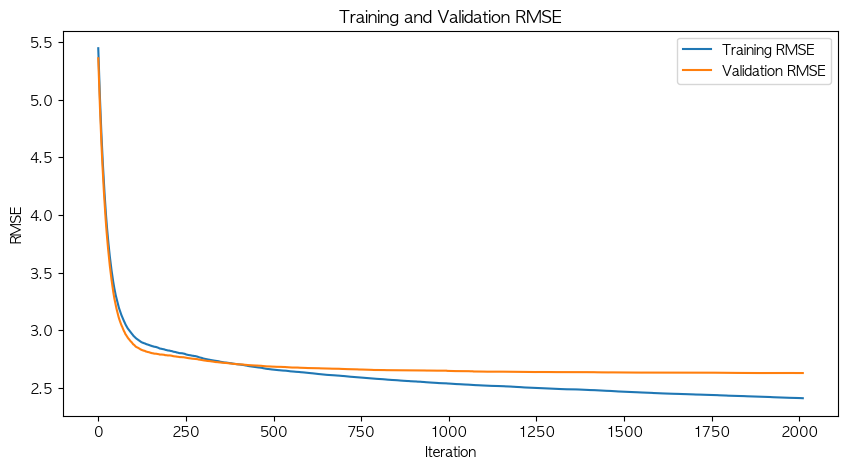

6번째 fold - MAE: 0.871344173780512, MSE: 6.905598085282958, RMSE: 2.627850468592716, R-squared: 0.7678881540161658
--------6번째 fold는 kfold6_cat.pkl에 저장되었습니다.--------


--------7번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.028815
0:	learn: 5.3279619	test: 6.3406313	best: 6.3406313 (0)	total: 120ms	remaining: 19m 59s
100:	learn: 2.7736496	test: 4.2537750	best: 4.2537750 (100)	total: 10.4s	remaining: 16m 57s
200:	learn: 2.6552173	test: 4.1839691	best: 4.1839691 (200)	total: 18.5s	remaining: 15m 1s
300:	learn: 2.5889669	test: 4.1573528	best: 4.1573528 (300)	total: 27.2s	remaining: 14m 37s
400:	learn: 2.5410177	test: 4.1381088	best: 4.1381088 (400)	total: 36.3s	remaining: 14m 29s
500:	learn: 2.5122875	test: 4.1246360	best: 4.1246360 (500)	total: 45.4s	remaining: 14m 20s
600:	learn: 2.4852874	test: 4.1183790	best: 4.1181364 (596)	total: 54.9s	remaining: 14m 19s
700:	learn: 2.4640731	test: 4.1169898	best: 4.1165879 (693)	total: 1m 4s	remaining: 14m 15s
Stopped by overfitting detector  (1

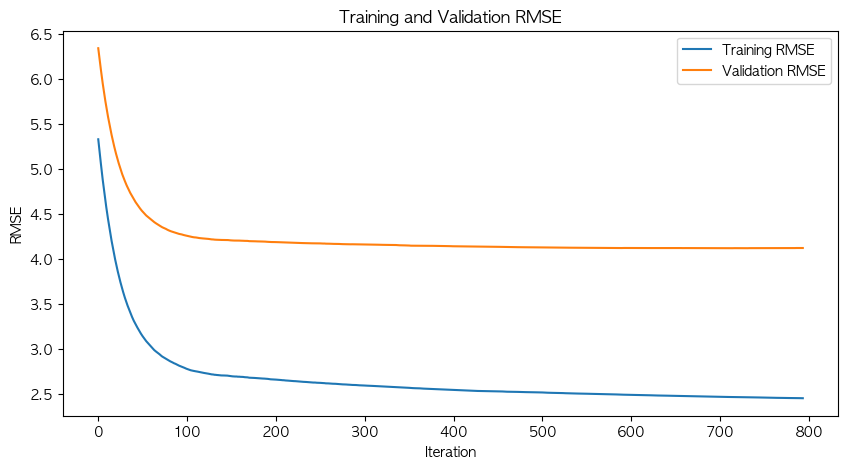

7번째 fold - MAE: 0.9212528803754226, MSE: 16.94376193332674, RMSE: 4.116280108705764, R-squared: 0.5898256274923901
--------7번째 fold는 kfold7_cat.pkl에 저장되었습니다.--------


--------8번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.028815
0:	learn: 5.4740853	test: 5.0917955	best: 5.0917955 (0)	total: 115ms	remaining: 19m 8s
100:	learn: 2.9730867	test: 2.6262641	best: 2.6262641 (100)	total: 10.3s	remaining: 16m 45s
200:	learn: 2.8537473	test: 2.5664392	best: 2.5664392 (200)	total: 19s	remaining: 15m 25s
300:	learn: 2.7759363	test: 2.5335850	best: 2.5335849 (299)	total: 27.5s	remaining: 14m 47s
400:	learn: 2.7146468	test: 2.5173742	best: 2.5173742 (400)	total: 36.7s	remaining: 14m 38s
500:	learn: 2.6699691	test: 2.5094358	best: 2.5081644 (494)	total: 46.7s	remaining: 14m 45s
600:	learn: 2.6336099	test: 2.5042910	best: 2.5039738 (597)	total: 56.5s	remaining: 14m 43s
700:	learn: 2.6135917	test: 2.5044232	best: 2.5038756 (653)	total: 1m 6s	remaining: 14m 37s
Stopped by overfitting detector  (10

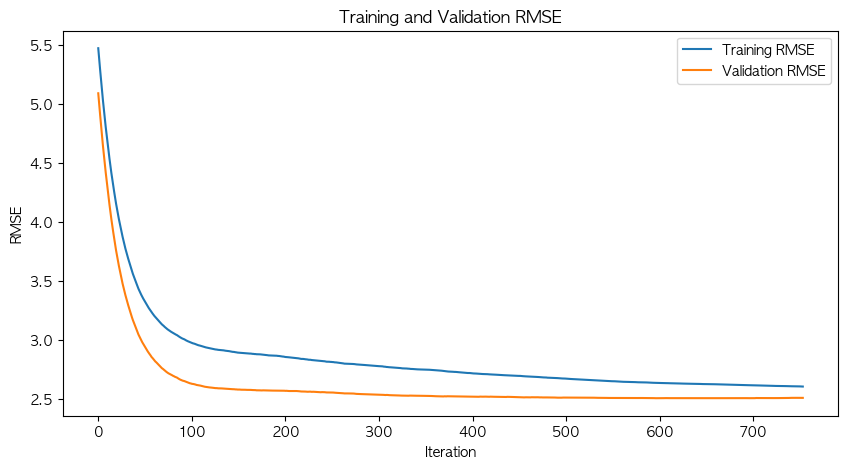

8번째 fold - MAE: 0.8694887665023849, MSE: 6.267346248496431, RMSE: 2.503466845895194, R-squared: 0.7673028765162518
--------8번째 fold는 kfold8_cat.pkl에 저장되었습니다.--------


--------9번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.028815
0:	learn: 5.4366676	test: 5.4451685	best: 5.4451685 (0)	total: 114ms	remaining: 18m 58s
100:	learn: 2.9525079	test: 2.9069163	best: 2.9069163 (100)	total: 10.3s	remaining: 16m 45s
200:	learn: 2.8144119	test: 2.8033988	best: 2.8033988 (200)	total: 19.2s	remaining: 15m 34s
300:	learn: 2.7400955	test: 2.7530013	best: 2.7530013 (300)	total: 28.1s	remaining: 15m 4s
400:	learn: 2.6846063	test: 2.7129811	best: 2.7129811 (400)	total: 37.5s	remaining: 14m 57s
500:	learn: 2.6498213	test: 2.6850551	best: 2.6850551 (500)	total: 47.1s	remaining: 14m 53s
600:	learn: 2.6197970	test: 2.6596807	best: 2.6596807 (600)	total: 57s	remaining: 14m 50s
700:	learn: 2.5955165	test: 2.6478346	best: 2.6477538 (698)	total: 1m 6s	remaining: 14m 46s
800:	learn: 2.5760799	test: 2.622788

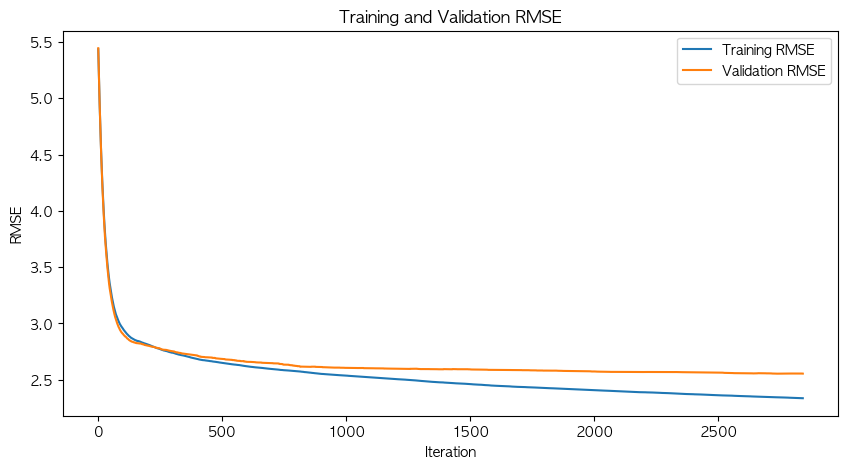

9번째 fold - MAE: 0.8610335544307307, MSE: 6.521269771723371, RMSE: 2.5536776953490765, R-squared: 0.7878322830617708
--------9번째 fold는 kfold9_cat.pkl에 저장되었습니다.--------




In [2469]:
min_rmse = float('inf')
best_predict = None
best_model = None
total_predictions = []
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    print(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트와 평가세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    y_train_fold = y_train[train_idx]
    X_valid_fold = X_train.iloc[valid_idx, :]
    y_valid_fold = y_train[valid_idx]

    # CatBoostRegressor 모델 초기화
    model = CatBoostRegressor(iterations=10000, random_state=42, loss_function='RMSE') # iterations=10000, loss_function='RMSE'

    # fold의 데이터로 학습을 진행합니다.
    model.fit(X_train_fold, y_train_fold, eval_set=(X_valid_fold, y_valid_fold),
              cat_features=categorical_columns_v2[1:], early_stopping_rounds=100, verbose=100) # 50

    results = model.get_evals_result()

    # 훈련 및 검증 데이터셋에 대한 RMSE 그리기
    plt.figure(figsize=(10, 5))
    plt.plot(results['learn']['RMSE'], label='Training RMSE')
    plt.plot(results['validation']['RMSE'], label='Validation RMSE')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('Training and Validation RMSE')
    plt.legend()
    plt.show()
    
    fold_predicts = model.predict(X_valid_fold)

    # 예측값을 1 이상으로 조정
    fold_predicts = np.maximum(fold_predicts, 1)

    # 평가지표 계산
    mae = mean_absolute_error(y_valid_fold, fold_predicts)
    mse = mean_squared_error(y_valid_fold, fold_predicts)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_valid_fold, fold_predicts)

    print(f"{fold_idx}번째 fold - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R-squared: {r2}")

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"kfold{fold_idx}_cat.pkl"
    joblib.dump(model, file_name)
    print(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)

In [2470]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predictions = []
min_rmse = float('inf')
best_predict = None
best_model = None

for file_name in fold_save_files:
    cat_trained = joblib.load(file_name)
    fold_predicts = cat_trained.predict(X_test)

    # 예측값을 0 이상으로 조정
    fold_predicts = np.maximum(fold_predicts, 1)

    # 평가지표 계산
    mae = mean_absolute_error(y_test, fold_predicts)
    mse = mean_squared_error(y_test, fold_predicts)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, fold_predicts)

    print(f"{file_name} - Test MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R-squared: {r2}")

    # 최소 RMSE를 갖는 모델을 추적합니다.
    if rmse < min_rmse:
        min_rmse = rmse
        best_predict = fold_predicts
        best_model = model

    # 각 fold의 예측값을 리스트에 추가합니다.
    total_predictions.append(fold_predicts)


# 예측값의 평균을 계산합니다.
average_predictions = np.mean(total_predictions, axis=0)

# 평균 예측에 대한 RMSE를 계산합니다.
average_rmse = np.sqrt(mean_squared_error(y_test, average_predictions))

print(f"최소 RMSE: {min_rmse}")
print(f"평균 예측 RMSE: {average_rmse}")

# 최종 예측을 선택합니다.
if average_rmse < min_rmse:
    pred = average_predictions
    average = True
    print("최종 선택은 평균값 모델")
else:
    pred = best_predict
    best_model = best_model
    average = False
    print("최종 선택은 Best 모델 1개")

kfold0_cat.pkl - Test MAE: 0.8762437718821477, MSE: 5.515864614055933, RMSE: 2.348587791430402, R-squared: 0.802045296396236
kfold1_cat.pkl - Test MAE: 0.8523126213523621, MSE: 5.304654321615405, RMSE: 2.303183518874561, R-squared: 0.8096252632307348
kfold2_cat.pkl - Test MAE: 0.8527826013615623, MSE: 5.534763217936674, RMSE: 2.3526077484223062, R-squared: 0.8013670586599065
kfold3_cat.pkl - Test MAE: 0.8599105445582109, MSE: 5.85119540804122, RMSE: 2.418924432065049, R-squared: 0.7900108625264458
kfold4_cat.pkl - Test MAE: 0.856177813175804, MSE: 5.386029383795406, RMSE: 2.3207820629683016, R-squared: 0.8067048550188416
kfold5_cat.pkl - Test MAE: 0.8537708514697894, MSE: 5.497235154669708, RMSE: 2.3446183388069173, R-squared: 0.802713875008862
kfold6_cat.pkl - Test MAE: 0.8540363004647317, MSE: 5.351256199434086, RMSE: 2.3132782364934155, R-squared: 0.8079528035972137
kfold7_cat.pkl - Test MAE: 0.8704281670711556, MSE: 5.448132356129783, RMSE: 2.3341234663422976, R-squared: 0.80447608

In [2136]:

# # 학습 데이터를 Kfold로 나눕니다.
# train_folds = list(kf.split(X_train, y_train))

# for idx in range(5):
#     # 세 번째 Fold의 훈련 데이터와 검증 데이터 인덱스
#     train_idx, valid_idx = train_folds[idx]
    
#     # 세 번째 Fold의 y_train 값
#     y_train_fold = y_train[train_idx]
#     y_valid_fold = y_train[valid_idx]
    
#     # 분석을 위한 기초 통계량 계산
#     y_train_fold_mean = np.mean(y_train_fold)
#     y_valid_fold_mean = np.mean(y_valid_fold)
    
#     y_train_fold_std = np.std(y_train_fold)
#     y_valid_fold_std = np.std(y_valid_fold)
    
#     print(y_train_fold_mean, y_valid_fold_mean, y_train_fold_std, y_valid_fold_std)
    
#     y_train_fold_max = np.max(y_train_fold)
#     y_valid_fold_max = np.max(y_valid_fold)
    
#     y_train_fold_min = np.min(y_train_fold)
#     y_valid_fold_min = np.min(y_valid_fold)
    
#     print(y_train_fold_max, y_valid_fold_max, y_train_fold_min, y_valid_fold_min)

3.5939894741478025 3.5955914736193075 5.578884320793757 5.353289870905415
386.0 124.0 1.0 1.0
3.5921122170351447 3.6031005020699376 5.568227465561394 5.397480016435903
386.0 176.0 1.0 1.0
3.5900587950321503 3.6113141900819166 5.5262792385414246 5.567234971818583
386.0 198.0 1.0 1.0
3.594716154320444 3.5926847529287413 5.422702184460242 5.960764743532091
199.0 386.0 1.0 1.0
3.600672729674976 3.568858451510614 5.574843793564485 5.370025376585526
386.0 199.0 1.0 1.0


#### forward selection

In [649]:
%%time
from sklearn.model_selection import cross_val_score

# # 데이터셋 샘플링: X와 y에서 각각 20%를 샘플링
# X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.8, random_state=42)
X_sample = X
y_sample = y

# 초기 설정
cat_features = categorical_columns_v2[1:]  # 범주형 변수 목록
selected_features = []  # 선택된 특성 목록
remaining_features = X_sample.columns.tolist()  # 남아 있는 특성 목록
best_score = -np.inf
scores_history = []

# forward selection 실행
while len(remaining_features) > 0:
    scores_with_feature_added = []
    
    for feature in tqdm(remaining_features, desc="Feature addition"):
        temp_features = selected_features + [feature]
        
        # 범주형 변수 인덱스 업데이트
        cat_features_indices = [temp_features.index(feat) for feat in cat_features if feat in temp_features]
        
        # 모델 학습 및 교차 검증 점수 계산
        model = CatBoostRegressor(cat_features=cat_features_indices, random_state=42, logging_level='Silent')
        scores = cross_val_score(model, X_sample[temp_features], y_sample, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
        mean_score = np.mean(scores)
        scores_with_feature_added.append((mean_score, feature))

    # 가장 성능이 좋은 특성 조합 찾기
    scores_with_feature_added.sort(reverse=True, key=lambda x: x[0])  # 높은 점수가 좋은 점수임
    best_new_score, best_new_feature = scores_with_feature_added[0]
    
    # 성능이 이전 단계보다 좋아지지 않으면 중지
    if best_new_score <= best_score:
        break
    
    # 특성 추가 및 최고 점수 업데이트
    selected_features.append(best_new_feature)
    remaining_features.remove(best_new_feature)
    best_score = best_new_score
    scores_history.append(best_score)
    print(f"Added: {best_new_feature}, Score: {best_score}, Selected features: {len(selected_features)}")

Feature addition: 100%|██████████| 17/17 [07:53<00:00, 27.86s/it]


Added: quality, Score: -3.7634412528769574, Selected features: 1


Feature addition: 100%|██████████| 16/16 [11:52<00:00, 44.54s/it]


Added: duration, Score: -3.2834482354839594, Selected features: 2


Feature addition: 100%|██████████| 15/15 [13:19<00:00, 53.33s/it]


Added: subcontinent, Score: -3.044863289222655, Selected features: 3


Feature addition: 100%|██████████| 14/14 [19:14<00:00, 82.47s/it]


Added: traffic_source, Score: -2.940572459733121, Selected features: 4


Feature addition: 100%|██████████| 13/13 [23:44<00:00, 109.57s/it]


Added: OS, Score: -2.855278185739879, Selected features: 5


Feature addition: 100%|██████████| 12/12 [27:34<00:00, 137.88s/it]


Added: new, Score: -2.7814416553396666, Selected features: 6


Feature addition: 100%|██████████| 11/11 [26:00<00:00, 141.89s/it]


Added: browser, Score: -2.712358629039631, Selected features: 7


Feature addition: 100%|██████████| 10/10 [29:22<00:00, 176.27s/it]


Added: transaction, Score: -2.7049098916139287, Selected features: 8


Feature addition: 100%|██████████| 9/9 [26:47<00:00, 178.63s/it]


Added: referral_path, Score: -2.699862269440748, Selected features: 9


Feature addition: 100%|██████████| 8/8 [31:16<00:00, 234.55s/it]


Added: country, Score: -2.6926982220881994, Selected features: 10


Feature addition: 100%|██████████| 7/7 [29:12<00:00, 250.38s/it]


Added: transaction_revenue, Score: -2.6919576332601243, Selected features: 11


Feature addition: 100%|██████████| 6/6 [25:49<00:00, 258.33s/it]


Added: userID, Score: -2.6894814081579446, Selected features: 12


Feature addition: 100%|██████████| 5/5 [29:07<00:00, 349.41s/it]

CPU times: user 24.4 s, sys: 10.2 s, total: 34.6 s
Wall time: 5h 1min 17s


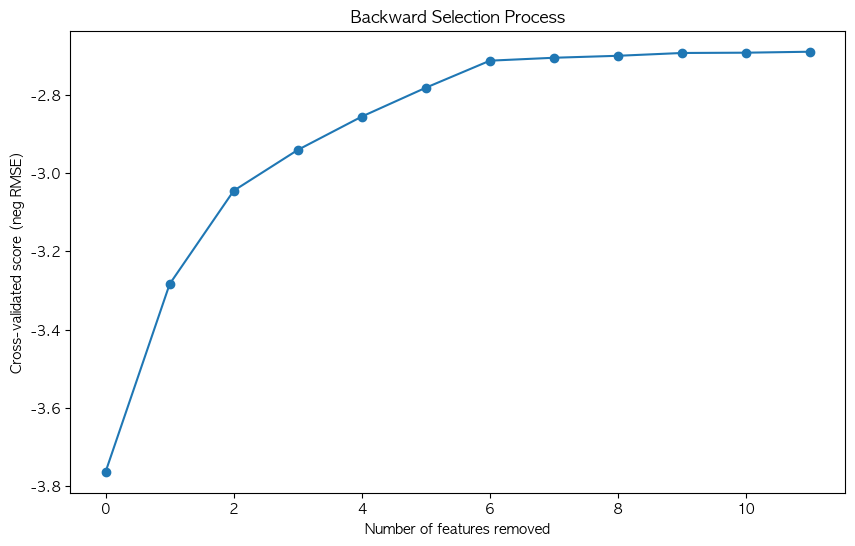

In [870]:
# 시각화
plt.figure(figsize=(10, 6))
plt.plot(scores_history, marker='o')
plt.xlabel('Number of features removed')
plt.ylabel('Cross-validated score (neg RMSE)')
plt.title('Backward Selection Process')
#plt.gca().invert_xaxis()  # 특성이 제거될수록 왼쪽으로 이동하도록 x축을 반전
plt.show()

['quality', 'duration', 'subcontinent', 'new', 'OS', 'traffic_source', 'referral_path']

['quality', 'duration', 'subcontinent', traffic_source', 'OS', 'new', 'browser', 'transaction', 'referral_path', 'country', 'transaction_revenue', 'userID']

#### backward selection

In [871]:
%%time
# # 데이터셋 샘플링: X와 y에서 각각 20%를 샘플링
# X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.8, random_state=42)
X_sample = X
y_sample = y

# 초기 설정에 샘플링된 데이터셋 사용
cat_features = categorical_columns_v2[1:]  # 범주형 변수 목록
remaining_features = X_sample.columns.tolist()  # 남아 있는 특성 목록
best_score = np.inf
scores_history = []

# backward selection 실행
while len(remaining_features) > 0:
    scores_with_feature_removed = []
    
    # tqdm을 추가하여 진행 상황 표시
    for feature in tqdm(remaining_features, desc="Feature removal", leave=True):
        temp_features = remaining_features.copy()
        temp_features.remove(feature)
        
        # 범주형 변수 인덱스 업데이트
        cat_features_indices = [temp_features.index(feat) for feat in cat_features if feat in temp_features]
        
        # 모델 학습 및 교차 검증 점수 계산
        model = CatBoostRegressor(cat_features=cat_features_indices, random_state=42, logging_level='Silent')
        scores = cross_val_score(model, X_sample[temp_features], y_sample, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
        mean_score = np.mean(scores)
        scores_with_feature_removed.append((mean_score, feature))
    
    # 가장 성능이 좋은 특성 조합 찾기
    scores_with_feature_removed.sort(reverse=True)  # 높은 점수가 좋은 점수임
    best_feature_to_remove = scores_with_feature_removed[0][1]
    current_score = scores_with_feature_removed[0][0]
    
    # 성능이 향상되지 않으면 중지
    if current_score > best_score:
        break
    
    # 특성 제거 및 최고 점수 업데이트
    remaining_features.remove(best_feature_to_remove)
    best_score = current_score
    scores_history.append(best_score)
    print(f"Removed: {best_feature_to_remove}, Score: {best_score}, Remaining features: {len(remaining_features)}")

Feature removal: 100%|██████████| 17/17 [2:07:21<00:00, 449.50s/it] 


Removed: device, Score: -2.6863287591787346, Remaining features: 16


Feature removal: 100%|██████████| 16/16 [10:22:34<00:00, 2334.66s/it]  


Removed: transaction_revenue, Score: -2.6865269516345185, Remaining features: 15


Feature removal: 100%|██████████| 15/15 [1:38:28<00:00, 393.89s/it]

CPU times: user 34.4 s, sys: 11.9 s, total: 46.3 s
Wall time: 14h 8min 24s


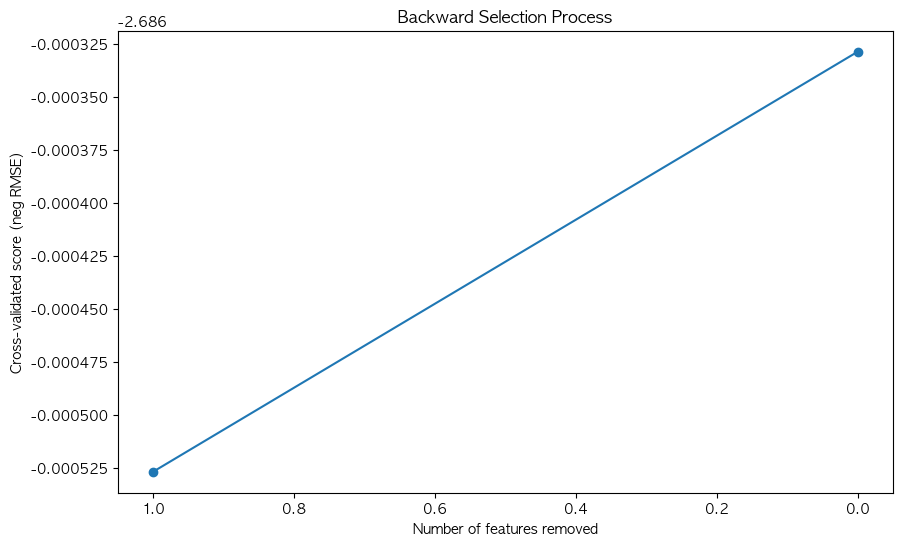

In [872]:
# 시각화
plt.figure(figsize=(10, 6))
plt.plot(scores_history, marker='o')
plt.xlabel('Number of features removed')
plt.ylabel('Cross-validated score (neg RMSE)')
plt.title('Backward Selection Process')
plt.gca().invert_xaxis()  # 특성이 제거될수록 왼쪽으로 이동하도록 x축을 반전
plt.show()

### 7.2.XGB

#### Holdout

In [2645]:
%%time
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_val)
best_model = model

CPU times: user 19.2 s, sys: 61.6 ms, total: 19.2 s
Wall time: 19.3 s


In [2646]:
# MAE 계산
mae = mean_absolute_error(y_val, pred)
print(f"Mean Absolute Error: {mae}")

# MSE 계산
mse = mean_squared_error(y_val, pred)
print(f"Mean Squared Error: {mse}")

# RMSE 계산
rmse = mean_squared_error(y_val, pred, squared=False)
print(f"Root Mean Squared Error: {rmse}")

# R-squared 계산
r2 = r2_score(y_val, pred)
print(f"R-squared: {r2}")

Mean Absolute Error: 0.9826499730873086
Mean Squared Error: 11.644944451652421
Root Mean Squared Error: 3.4124689671339756
R-squared: 0.6756498974692133


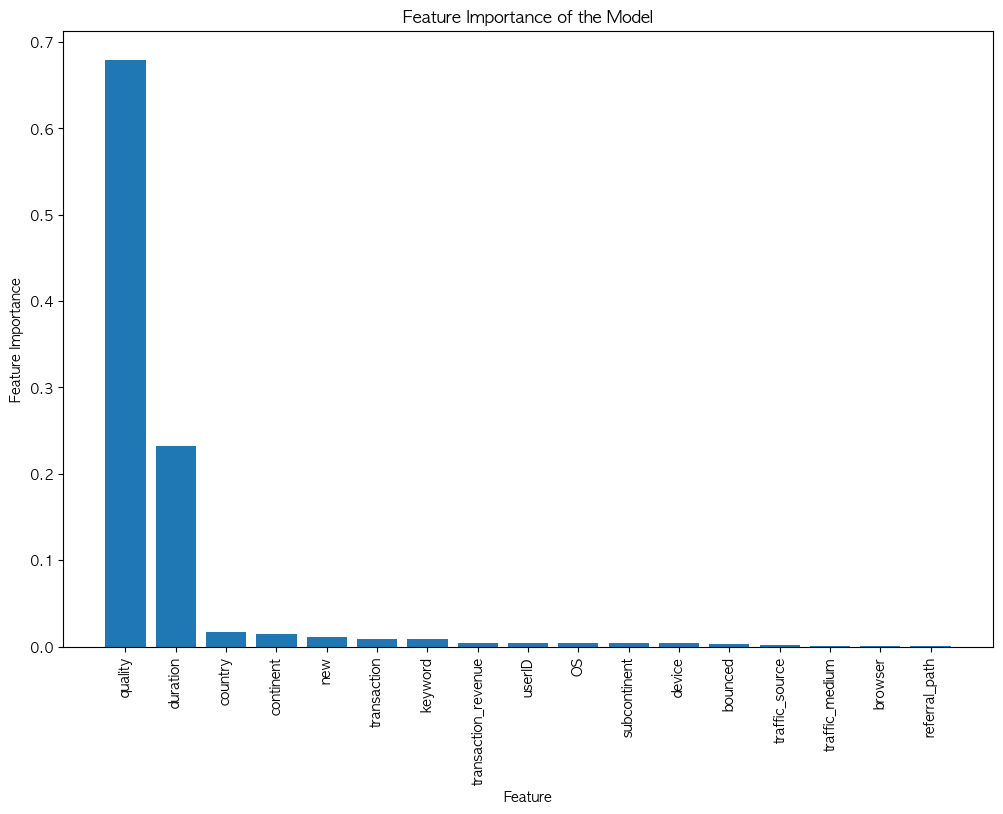

In [2647]:
# 모델의 feature 중요도
feature_importance = model.feature_importances_

# feature 이름 (열 이름)
feature_names = X_train.columns

# 중요도를 내림차순으로 정렬
sorted_idx = feature_importance.argsort()[::-1]

# 가장 중요한 feature 순으로 정렬된 feature 중요도를 그래프로 표시
plt.figure(figsize=(12, 8))
plt.bar(range(len(feature_names)), feature_importance[sorted_idx], align="center")
plt.xticks(range(len(feature_names)), feature_names[sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Feature Importance of the Model")
plt.show()

#### K-fold

In [2636]:
# 학습 데이터를 Kfold로 나눕니다.
train_folds = kf.split(X_train, y_train)
display(train_folds)

<generator object _BaseKFold.split at 0x7fcdc38d8270>

In [2638]:
min_rmse = float('inf')
best_predict = None
best_model = None
total_predictions = []
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    print(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트와 평가세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    y_train_fold = y_train[train_idx]
    X_valid_fold = X_train.iloc[valid_idx, :]
    y_valid_fold = y_train[valid_idx]

    # CatBoostRegressor 모델 초기화
    model = GradientBoostingRegressor(random_state=42)

    # fold의 데이터로 학습을 진행합니다.
    model.fit(X_train_fold, y_train_fold)
    # 학습된 모델로 평가 데이터에 대한 예측을 수행합니다.
    fold_predicts = model.predict(X_valid_fold)

    # 평가지표 계산
    mae = mean_absolute_error(y_valid_fold, fold_predicts)
    mse = mean_squared_error(y_valid_fold, fold_predicts)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_valid_fold, fold_predicts)

    print(f"{fold_idx}번째 fold - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R-squared: {r2}")

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"kfold{fold_idx}_xgb.pkl"
    joblib.dump(model, file_name)
    print(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)

--------0번째 fold의 학습을 시작합니다.--------
0번째 fold - MAE: 0.9845708087277126, MSE: 8.84121076495781, RMSE: 2.973417354654037, R-squared: 0.7022363112268266
--------0번째 fold는 kfold0_xgb.pkl에 저장되었습니다.--------


--------1번째 fold의 학습을 시작합니다.--------
1번째 fold - MAE: 0.979342342831161, MSE: 10.863349594340043, RMSE: 3.2959595862722653, R-squared: 0.6763563253796976
--------1번째 fold는 kfold1_xgb.pkl에 저장되었습니다.--------


--------2번째 fold의 학습을 시작합니다.--------
2번째 fold - MAE: 0.9817875388620104, MSE: 8.20483739278177, RMSE: 2.8644087335402695, R-squared: 0.7189200692975366
--------2번째 fold는 kfold2_xgb.pkl에 저장되었습니다.--------


--------3번째 fold의 학습을 시작합니다.--------
3번째 fold - MAE: 0.991261800588974, MSE: 8.3135326946984, RMSE: 2.8833197350794104, R-squared: 0.7268590688351435
--------3번째 fold는 kfold3_xgb.pkl에 저장되었습니다.--------




In [2639]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predictions = []
min_rmse = float('inf')
best_predict = None
best_model = None

for file_name in fold_save_files:
    xgb_trained = joblib.load(file_name)
    fold_predicts = xgb_trained.predict(X_test)

    # 평가지표 계산
    mae = mean_absolute_error(y_test, fold_predicts)
    mse = mean_squared_error(y_test, fold_predicts)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, fold_predicts)

    print(f"{file_name} - Test MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R-squared: {r2}")

    # 최소 RMSE를 갖는 모델을 추적합니다.
    if rmse < min_rmse:
        min_rmse = rmse
        best_predict = fold_predicts
        best_model = model

    # 각 fold의 예측값을 리스트에 추가합니다.
    total_predictions.append(fold_predicts)


# 예측값의 평균을 계산합니다.
average_predictions = np.mean(total_predictions, axis=0)

# 평균 예측에 대한 RMSE를 계산합니다.
average_rmse = np.sqrt(mean_squared_error(y_test, average_predictions))

print(f"최소 RMSE: {min_rmse}")
print(f"평균 예측 RMSE: {average_rmse}")

# 최종 예측을 선택합니다.
if average_rmse < min_rmse:
    pred = average_predictions
    average = True
    print("최종 선택은 평균값 모델")
else:
    pred = best_predict
    best_model = best_model
    average = False
    print("최종 선택은 Best 모델 1개")

kfold0_xgb.pkl - Test MAE: 1.007771074963158, MSE: 11.082468844011203, RMSE: 3.329034220913207, R-squared: 0.6823908648178354
kfold1_xgb.pkl - Test MAE: 0.9988947251291733, MSE: 10.79525893285697, RMSE: 3.2856139354551335, R-squared: 0.6906219271182484
kfold2_xgb.pkl - Test MAE: 1.0060261916876676, MSE: 10.810983545066932, RMSE: 3.2880060135387423, R-squared: 0.6901712801951326
kfold3_xgb.pkl - Test MAE: 1.0043218335777966, MSE: 10.809356266621501, RMSE: 3.28775854749425, R-squared: 0.6902179158777615
최소 RMSE: 3.2856139354551335
평균 예측 RMSE: 3.2818786422670545
최종 선택은 평균값 모델


In [2656]:
sfs = SFS(GradientBoostingRegressor(random_state=42),
          forward=False, # forward = True이면 forward selection을 뜻합니다.
          floating=True,
          scoring="neg_mean_squared_error",
          cv=5)

display(sfs)

SequentialFeatureSelector(estimator=GradientBoostingRegressor(random_state=42),
                          floating=True, forward=False,
                          scoring='neg_mean_squared_error')

('quality',)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Number of Features', ylabel='Performance'>)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
17,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-7.178937599602812, -9.480876212093552, -7.83...",-8.645654,"(userID, browser, OS, device, new, quality, du...",1.409166,1.096379,0.54819
16,"(0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[-7.208636194950415, -9.655813840581803, -7.88...",-8.538037,"(userID, browser, device, new, quality, durati...",1.193368,0.928481,0.46424
15,"(0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15...","[-7.265642474004217, -9.678459202568195, -7.93...",-8.643116,"(userID, browser, device, new, quality, durati...",1.158851,0.901625,0.450813
14,"(0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16)","[-7.225292167205993, -9.642233057527969, -7.87...",-8.449855,"(userID, browser, device, new, quality, durati...",1.068466,0.831303,0.415651
13,"(0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 13, 15, 16)","[-7.226603030954802, -9.645330040098294, -7.81...",-8.440738,"(userID, browser, device, new, quality, durati...",1.083331,0.842869,0.421434
12,"(0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 15, 16)","[-7.305744078565198, -9.755553711202518, -7.89...",-8.636392,"(userID, browser, device, new, quality, durati...",1.264843,0.984091,0.492045
11,"(0, 1, 3, 4, 5, 6, 11, 13, 14, 15, 16)","[-7.288748373230761, -9.639987259882869, -7.68...",-8.39849,"(userID, browser, device, new, quality, durati...",1.088421,0.846829,0.423414
10,"(0, 1, 2, 3, 4, 5, 6, 11, 13, 16)","[-7.163527601736745, -9.592959411265419, -7.70...",-8.413432,"(userID, browser, OS, device, new, quality, du...",1.146364,0.89191,0.445955
9,"(0, 1, 2, 3, 4, 5, 6, 11, 13)","[-7.212576955877004, -9.595229023612726, -7.67...",-8.380769,"(userID, browser, OS, device, new, quality, du...",1.102918,0.858107,0.429054
8,"(0, 1, 2, 4, 5, 6, 11, 13)","[-7.302042045858957, -9.59077174456512, -7.709...",-8.375272,"(userID, browser, OS, new, quality, duration, ...",1.086627,0.845433,0.422716


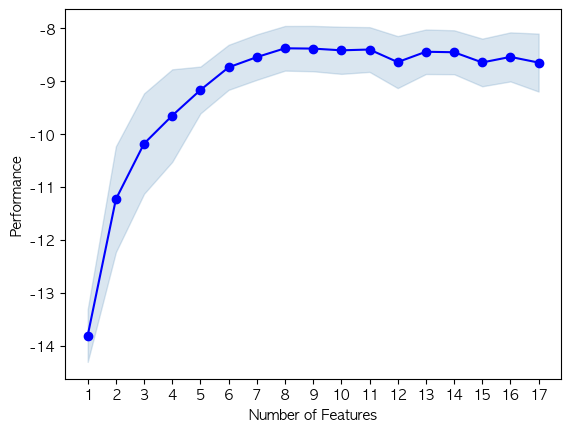

In [2657]:
sfs.fit(X_train, y_train)
display(sfs.k_feature_names_)
display(plot_sfs(sfs.get_metric_dict(), kind='std_err'))
display(pd.DataFrame.from_dict(sfs.get_metric_dict()).T)

In [2661]:
selected = [[0, 1, 3, 4, 5, 6, 11, 13, 14, 15, 16], [0, 1, 2, 3, 4, 5, 6, 11, 13, 16],
            [0, 1, 2, 3, 4, 5, 6, 11, 13], [0, 1, 2, 4, 5, 6, 11, 13]]
for select in selected:
    print(len(select), "개 column 시작")
    train_folds = kf.split(X_train, y_train)
    TP_X_train = X_train.iloc[:, select]
    TP_X_test = X_test.iloc[:, select]

    min_rmse = float('inf')
    best_predict = None
    best_model = None
    total_predictions = []
    fold_save_files = []
    
    for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
        print(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")
    
        # index를 통해 fold의 학습세트와 평가세트를 가져옵니다.
        X_train_fold = TP_X_train.iloc[train_idx, :]
        y_train_fold = y_train[train_idx]
        X_valid_fold = TP_X_train.iloc[valid_idx, :]
        y_valid_fold = y_train[valid_idx]
    
        # CatBoostRegressor 모델 초기화
        model = GradientBoostingRegressor(random_state=42)
    
        # fold의 데이터로 학습을 진행합니다.
        model.fit(X_train_fold, y_train_fold)
        # 학습된 모델로 평가 데이터에 대한 예측을 수행합니다.
        fold_predicts = model.predict(X_valid_fold)
    
        # 평가지표 계산
        mae = mean_absolute_error(y_valid_fold, fold_predicts)
        mse = mean_squared_error(y_valid_fold, fold_predicts)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_valid_fold, fold_predicts)
    
        print(f"{fold_idx}번째 fold - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R-squared: {r2}")
        
        fold_predicts = model.predict(TP_X_test)
        # 평가지표 계산
        mae = mean_absolute_error(y_test, fold_predicts)
        mse = mean_squared_error(y_test, fold_predicts)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, fold_predicts)
        print(f"{fold_idx}번째 - Test MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R-squared: {r2}")

        # 최소 RMSE를 갖는 모델을 추적합니다.
        if rmse < min_rmse:
            min_rmse = rmse
            best_predict = fold_predicts
            best_model = model
    
        # 각 fold의 예측값을 리스트에 추가합니다.
        total_predictions.append(fold_predicts)
    
    
    # 예측값의 평균을 계산합니다.
    average_predictions = np.mean(total_predictions, axis=0)
        
    # 평균 예측에 대한 RMSE를 계산합니다.
    average_rmse = np.sqrt(mean_squared_error(y_test, average_predictions))
        
    print(f"최소 RMSE: {min_rmse}")
    print(f"평균 예측 RMSE: {average_rmse}")
        
    # 최종 예측을 선택합니다.
    if average_rmse < min_rmse:
        pred = average_predictions
        average = True
        print("최종 선택은 평균값 모델")
    else:
        pred = best_predict
        best_model = best_model
        average = False
        print("최종 선택은 Best 모델 1개")


11 개 column 시작
--------0번째 fold의 학습을 시작합니다.--------
0번째 fold - MAE: 0.9546100151275125, MSE: 7.288748373230761, RMSE: 2.699768207315354, R-squared: 0.752509274100164
0번째 - Test MAE: 0.9928506570588035, MSE: 11.964587414208877, RMSE: 3.4589864721055035, R-squared: 0.692641689722272
--------1번째 fold의 학습을 시작합니다.--------
1번째 fold - MAE: 0.9684638766775994, MSE: 9.639987259882869, RMSE: 3.104832887593609, R-squared: 0.6977218235506442
1번째 - Test MAE: 0.995189744742565, MSE: 13.023677335386845, RMSE: 3.6088332374033087, R-squared: 0.6654347265954991
--------2번째 fold의 학습을 시작합니다.--------
2번째 fold - MAE: 0.9496658404530458, MSE: 7.68833302202846, RMSE: 2.772784344666649, R-squared: 0.7289844009271982
2번째 - Test MAE: 1.0020329012524227, MSE: 12.221025756532264, RMSE: 3.495858371921303, R-squared: 0.6860540446277714
--------3번째 fold의 학습을 시작합니다.--------
3번째 fold - MAE: 0.9731270045258943, MSE: 8.953356639643697, RMSE: 2.992216008185856, R-squared: 0.7049350420117775
3번째 - Test MAE: 1.0007466066618

## 8. 제출

In [2337]:
# model = Catboostregressor(random_state=41)
# model.fit(X, y)
# preds = model.predict(test.drop(columns=['sessionID']))

NameError: name 'Catboostregressor' is not defined

In [2338]:
# preds = best_model.predict(test.drop(columns=['sessionID']))

In [852]:
# average = True

In [2012]:
if average:
    # 모든 fold에서 학습된 모델을 사용하여 테스트 데이터셋에 대한 예측을 수행합니다.
    test_predictions = []  # 각 모델의 예측값을 저장할 리스트
    
    for file_name in fold_save_files:
        model = joblib.load(file_name)  # 모델 불러오기
        predictions = model.predict(test.drop(columns=['sessionID']))  # 테스트 데이터셋에 대한 예측
        test_predictions.append(predictions)  # 예측값을 리스트에 추가
    
    # 예측값의 평균을 계산
    preds = np.mean(test_predictions, axis=0)
    print("average 예측")
else:
    preds = best_model.predict(test.drop(columns=['sessionID']))
    print("best model 예측")

best model 예측


In [2013]:
submission = pd.read_csv('./sample_submission.csv')
submission

,sessionID,TARGET
0,SESSION_252289,0
1,SESSION_252290,0
2,SESSION_252291,0
3,SESSION_252292,0
4,SESSION_252293,0
...,...,...
79781,SESSION_332070,0
79782,SESSION_332071,0
79783,SESSION_332072,0
79784,SESSION_332073,0


In [2014]:
#preds = preds.reshape(-1, 1)
#preds = scaler.inverse_transform(preds)
# submission['TARGET'] = np.expm1(preds)
preds = np.where(preds < 1, 1, preds)
submission['TARGET'] = preds
submission

,sessionID,TARGET
0,SESSION_252289,24.142937
1,SESSION_252290,0.951622
2,SESSION_252291,2.828038
3,SESSION_252292,4.343104
4,SESSION_252293,10.213342
...,...,...
79781,SESSION_332070,0.942850
79782,SESSION_332071,1.054836
79783,SESSION_332072,2.782575
79784,SESSION_332073,4.977374


In [2020]:
submission.to_csv(f"cat_kfold_240304(1).csv", index=False)

## 결과 분석

In [2015]:
submission.describe()

,TARGET
count,79786.000000
mean,3.675478
std,4.856415
min,0.000000
25%,1.016712
50%,1.507866
75%,4.030669
max,121.362037


In [1673]:
best_score_df = pd.read_csv('./cat_h_240227(1).csv')
best_score_df

,sessionID,TARGET
0,SESSION_252289,27.483208
1,SESSION_252290,1.049477
2,SESSION_252291,2.738626
3,SESSION_252292,4.207803
4,SESSION_252293,10.696012
...,...,...
79781,SESSION_332070,0.856737
79782,SESSION_332071,1.018339
79783,SESSION_332072,2.847007
79784,SESSION_332073,5.056773


In [2016]:
best_score_df.describe()

,TARGET
count,79786.000000
mean,3.680329
std,4.865749
min,-2.275262
25%,1.011561
50%,1.531277
75%,4.010194
max,85.558147


In [2017]:
best_score_df[best_score_df.TARGET > 50] # 8, 13, 26

,sessionID,TARGET
4439,SESSION_256728,75.289404
10357,SESSION_262646,56.130837
28087,SESSION_280376,66.250728
48487,SESSION_300776,50.028296
49859,SESSION_302148,77.138828
51844,SESSION_304133,59.922371
58858,SESSION_311147,85.558147
59147,SESSION_311436,50.914776
61217,SESSION_313506,58.221845
71980,SESSION_324269,52.552429


In [2018]:
submission[submission.TARGET > 50] # 8, 13, 26

,sessionID,TARGET
25089,SESSION_277378,50.859530
34845,SESSION_287134,51.186324
51844,SESSION_304133,90.941686
58858,SESSION_311147,121.362037
71980,SESSION_324269,62.309513
72914,SESSION_325203,92.204877


In [1795]:
best_score_df[best_score_df.TARGET < 0] # 8, 13, 26

,sessionID,TARGET
10040,SESSION_262329,-0.422682
10043,SESSION_262332,-2.275262
10089,SESSION_262378,-1.579480
35047,SESSION_287336,-0.834649
79245,SESSION_331534,-1.428506


In [2019]:
submission[submission.TARGET < 0] # 8, 13, 26

,sessionID,TARGET


In [1669]:
# best_score_df 데이터 프레임의 TARGET 열에서 0보다 작은 값을 찾아 0으로 치환
best_score_df['TARGET'] = best_score_df['TARGET'].apply(lambda x: 0 if x < 0 else x)
best_score_df

,sessionID,TARGET
0,SESSION_252289,27.483208
1,SESSION_252290,1.049477
2,SESSION_252291,2.738626
3,SESSION_252292,4.207803
4,SESSION_252293,10.696012
...,...,...
79781,SESSION_332070,0.856737
79782,SESSION_332071,1.018339
79783,SESSION_332072,2.847007
79784,SESSION_332073,5.056773


In [1670]:
best_score_df.describe()

,TARGET
count,79786.000000
mean,3.680411
std,4.865673
min,0.000000
25%,1.011561
50%,1.531277
75%,4.010194
max,85.558147


In [1671]:
best_score_df.to_csv(f"cat_kfold_240303(2).csv", index=False)